# Восстановление золота из руды


Для прогноза коэффициента нужно найти долю  золота в концентратах и хвостах.

Для этого **нужно спрогнозировать эффективность обогащения чернового и финального концентрата :**  
- **rougher.output.recovery**;  
- **final.output.recovery**.  

Итоговая метрика качества:  
**sMAPE = 0.25% sMAPE(Roughe) + 0.75% sMAPE(Final)**  

**Основные этапы:**

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

**Описание данных**  
  
**Технологический процесс**  
Rougher feed — исходное сырье  
Rougher additions — флотационные реагенты:Xanthate, Sulphate, Depressant.  
Rougher process — флотация  
Rougher tails — отвальные хвосты  
Float banks — флотационная установка  
Cleaner process — очистка  
Rougher Au — черновой концентрат золота  
Final Au — финальный концентрат золота    

**Параметры этапов**    
air amount — объём воздуха  
fluid levels — уровень жидкости  
feed size — размер гранул сырья  
feed rate — скорость подачи

**Наименование признаков**  
[этап].[тип_параметра].[название_параметра]  
Пример: rougher.input.feed_ag.

Возможные значения для блока [этап]:  
rougher — флотация  
primary_cleaner — первичная очистка  
secondary_cleaner — вторичная очистка  
final — финальные характеристики    

Возможные значения для блока [тип_параметра]:  
input — параметры сырья  
output — параметры продукта  
state — параметры, характеризующие текущее состояние этапа  
calculation — расчётные характеристики

In [ ]:
# Установка sweetviz
#!pip install sweetviz

In [ ]:
# Загружаем библиотеки
import pandas as pd
import numpy as np
from numpy.random import RandomState

import sweetviz as sv
import re

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error

pd.options.mode.chained_assignment = None

import seaborn as sns
from seaborn import kdeplot
import matplotlib.pyplot as plt

import time
import timeit
from datetime import datetime
from tqdm import tqdm
import os

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Используемые константы
RS = 1234 #random state

## 1 Подготовка данных

### 1.1 Откроем и изучим файлы.

In [ ]:
# Загружаем данные
pth1 = '/datasets/gold_recovery_train_new.csv'
pth2 = 'gold_recovery_train_new.csv'

if os.path.exists(pth1):
    data_1 = pd.read_csv(pth1)
    data_2 = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    data_3 = pd.read_csv('/datasets/gold_recovery_full_new.csv')

elif os.path.exists(pth2):
    data_1 = pd.read_csv(pth2)
    data_2 = pd.read_csv('gold_recovery_test_new.csv')
    data_3 = pd.read_csv('gold_recovery_full_new.csv')
#    print('Путь 2')
else:
    print('Ошибка загрузки данных, проверьте правильность пути, наличие файла')

In [ ]:
# Создадим копии данных, с которыми будем работать
train = data_1.copy()
test = data_2.copy()
full = data_3.copy()

In [ ]:
# Вспомогательные функции нахождения вхождения строки или строк в другую строку с начала/конца/середины
import pandas as pd

# Проверяет совпадение начала строки с маской или любой маской из списка.
# На вход принимаются маска и список масок, пустая строка, пустой список, None, по умолчанию None - не фильтровать.
# Вовзращает True/False
def startsWithAny(text, masks=None):
    if type(text) == str:
        vtype = type(masks)
        if masks == None or (vtype != list and vtype != str):
            return True
        if vtype == str:
            if masks == '':
                return True
            masks = [masks]
        if masks == []:
            return True

        for mask in masks:
            if text.startswith(mask):
                return True
    return False

# Проверяет совпадение конца строки с маской или любой маской из списка.
# На вход принимаются маска и список масок, пустая строка, пустой список, None, по умолчанию None - не фильтровать.
# Вовзращает True/False
def endsWithAny(text, masks=None):
    if type(text) == str:
        vtype = type(masks)
        if masks == None or (vtype != list and vtype != str):
            return True
        if vtype == str:
            if masks == '':
                return True
            masks = [masks]
        if masks == []:
            return True

        for mask in masks:
            if text.endswith(mask):
                return True
    return False

# Проверяет любое вхождение маски или любой маски из списка со строкой.
# На вход принимаются маска и список масок, пустая строка, пустой список, None, по умолчанию None - не фильтровать.
# Вовзращает True/False
def containsAny(text, masks=None):
    if type(text) == str:
        vtype = type(masks)
        if masks == None or (vtype != list and vtype != str):
            return True
        if vtype == str:
            if masks == '':
                return True
            masks = [masks]
        if masks == []:

            return True
        for mask in masks:
            if text.find(mask) > -1:
                return True
    return False

# Расширение класса DataFrame для фильтрации колонок по маскам с начала/конца и вхождения,
# получения их списка и нового DataFrame с отфильтрованными колонками
# На вход принимаются маска и список масок, пустая строка, пустой список, None, по умолчанию None - не фильтровать.
# Вовзращает список колонок
class MyExtDataFrame(pd.DataFrame):
    # Возвращает массив названий колонок, отфильтрованных по совпадениям
    # с маской с начала и с конца и любым вхождением
    def colsFilter(self, start=None, end=None, contains=None):
        return [i for i in self.columns \
                            if startsWithAny(i, start) \
                                and endsWithAny(i, end) \
                                and containsAny(i, contains) ]

    # Возвращает DataFrame с колоноками, отфильтрованными по совпадениям маскам
    # с начала и с конца и любым вхождением
    # На вход принимаются маска или список масок, пустая строка или пустой список,
    # None, по умолчанию None - не фильтровать.
    # Вовзращает DataFrame с отфильтрованными колонками
    def colsFiltered(self, start=None, end=None, contains=None):
        return MyExtDataFrame(self[self.colsFilter(start, end, contains)])

# Тесты расширения класса
import unittest

class Testing(unittest.TestCase):
    # Тестовый датасет
    df =  MyExtDataFrame(pd.DataFrame([{'startteststop': 1, 'begintestend': 2, 'gohomefriend': 3, 999: 0}]))
    print(df)
    # методы тестов
    def test_filter_by_string_start_filtered(self):
        mask = 'start'
        result = len(self.df.colsFilter(start=mask))
        # Проверка результата
        self.assertEqual(1, result)

    def test_filter_by_list_start_filtered(self):
        mask = ['begin', 'go']
        result = len(self.df.colsFilter(mask))
        # Проверка результата
        self.assertEqual(2, result)

    def test_filter_by_emptylist_start(self):
        mask = []
        result = len(self.df.colsFilter(start=mask))
        # Проверка результата
        self.assertEqual(3, result)

    def test_filter_by_emptylist_end(self):
        mask = []
        result = len(self.df.colsFilter(end=mask))
        # Проверка результата
        self.assertEqual(3, result)

    def test_filter_by_list_end(self):
        mask = ['end']
        result = len(self.df.colsFilter(end=mask))
        # Проверка результата
        self.assertEqual(2, result)

    def test_filter_by_list_startend(self):
        maskstart = ['go']
        maskend = ['end']
        result = len(self.df.colsFilter(start=maskstart, end=maskend))
        # Проверка результата
        self.assertEqual(1, result)

    def test_filter_by_list_contains(self):
        mask = ['home']
        result = len(self.df.colsFilter(contains=mask))
        # Проверка результата
        self.assertEqual(1, result)

    def test_filter_by_list_containsend(self):
        maskcontains = ['test']
        maskend=['end']
        result = len(self.df.colsFilter(contains=maskcontains, end=maskend))
        # Проверка результата
        self.assertEqual(1, result)

    def test_filtered_by_list_end(self):
        mask = ['end']
        resultdf = self.df.colsFiltered(end=mask)
        row_count = resultdf.shape[0]  # возвращает число строк
        col_count = resultdf.shape[1]  # возвращает число колонок
        # Проверка результата
        self.assertEqual(1, row_count)
        self.assertEqual(2, col_count)

if __name__ == '__main__':
# Запуск тестов
    unittest.main(argv=[''], verbosity=9, exit=False)

test_filter_by_emptylist_end (__main__.Testing) ... ok
test_filter_by_emptylist_start (__main__.Testing) ... ok
test_filter_by_list_contains (__main__.Testing) ... ok
test_filter_by_list_containsend (__main__.Testing) ... ok
test_filter_by_list_end (__main__.Testing) ... ok
test_filter_by_list_start_filtered (__main__.Testing) ... ok
test_filter_by_list_startend (__main__.Testing) ... ok
test_filter_by_string_start_filtered (__main__.Testing) ... ok
test_filtered_by_list_end (__main__.Testing) ... 

   startteststop  begintestend  gohomefriend  999
0              1             2             3    0


ok

----------------------------------------------------------------------
Ran 9 tests in 0.003s

OK


In [ ]:
#ldf.startWithAny('final', ['fi', 'dd'])

In [ ]:
# Создаем словарь исходных 3х таблиц (выборок)
dct = {'train': train, 'test': test, 'full': full}

In [ ]:
[display(dct[x].head(3)) for x in dct]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


[None, None, None]

In [ ]:
# Функция для построения отчета данных для выборок
def report_df(name_df):
    name_df = sv.analyze(dct[name_df])
    name_df.show_notebook(h='full')

In [ ]:
# Отчет данных для выборок автоматизированный
#list(map(lambda x: report_df(x), dct))

train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  fl

None

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
14147,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
14148,2018-08-18 10:59:59,3.598375,11.737832,6.717509,46.299438,70.281454,8.406690,2.517518,10.652193,1.389434,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575


'Явных дубликатов в train'

0

'Пропуски в train'

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

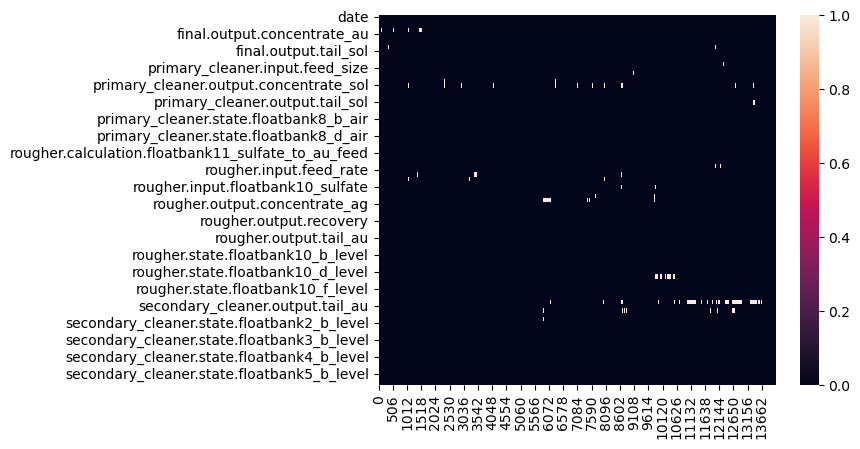

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary

None

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.08,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
5288,2017-12-31 22:59:59,179.697158,15.438979,8.07,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284
5289,2017-12-31 23:59:59,181.556856,14.995850,8.07,1.623454,1498.096303,-499.796922,1501.743791,-505.146931,1499.535978,...,20.034715,-500.728588,14.914199,-499.948518,10.986607,-500.658027,8.989497,-500.337588,8.988632,-500.764937


'Явных дубликатов в test'

0

'Пропуски в test'

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

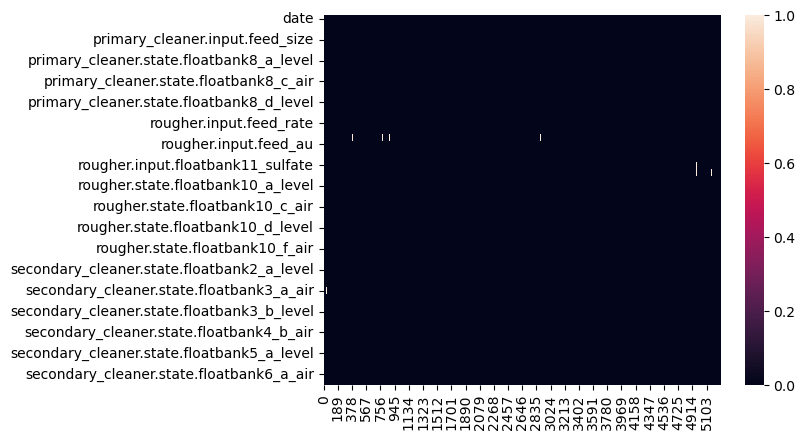

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


full
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  flo

None

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
19437,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
19438,2018-08-18 10:59:59,3.598375,11.737832,6.717509,46.299438,70.281454,8.406690,2.517518,10.652193,1.389434,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575


'Явных дубликатов в full'

0

'Пропуски в full'

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

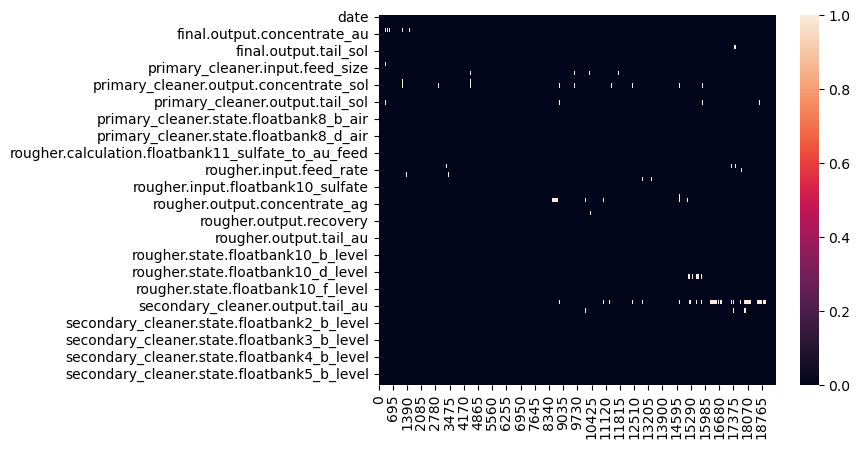

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


[[None,
  None,
  'Тепловая карта пропусков в train',
  <AxesSubplot: >,
  None,
  'Статистики таблицы train:',
  None],
 [None,
  None,
  'Тепловая карта пропусков в test',
  <AxesSubplot: >,
  None,
  'Статистики таблицы test:',
  None],
 [None,
  None,
  'Тепловая карта пропусков в full',
  <AxesSubplot: >,
  None,
  'Статистики таблицы full:',
  None]]

In [ ]:
# Выводим информацию, количество пропусков и явных дубликатов, первые и последние 5 строк каждой таблицы данных, статистики
list(map(lambda x: [print(x), display( \
                                      dct[x].info(), \
                                      dct[x].head(2), \
                                      dct[x].tail(2), \
                                      f'Явных дубликатов в {x}', dct[x].duplicated().sum(), \
                                      f'Пропуски в {x}', dct[x].isna().sum()), \
                                      f'Тепловая карта пропусков в {x}', sns.heatmap(dct[x].isna().transpose()), \
                                      plt.show(), \
                                      f'Статистики таблицы {x}:', display(dct[x].describe()) \
                   ], \
         dct))

In [ ]:
# Функция подсчета доли пропусков в заданных на входе таблице и порогом пропусков в %
# На выходе срез признаков с пропусками
def rate_na (df, rate):
    #считаем количество и долю (%) пропусков в каждом столбце
    na_sum = df.isna().sum()
    na_mean = df.isna().mean()*100

    #считаем количетво нулевых значений для каждого столбца
    is_null = []
    [is_null.append(df.loc[df[null] == 0, null].count()) for null in df.columns]
    data_info_in = pd.DataFrame({'Количество пропусков': na_sum, \
                                         'Количество пропусков в %': na_mean, \
                                         'Количество нулевых значений': is_null})

    #выводим пропуски с порогом в 3% и нулевые значения
    display(data_info_in[(data_info_in['Количество пропусков в %'] > rate) & (is_null !=0)])

In [ ]:
# Выводим пропуски в выборках
[[print(df), rate_na(dct[df], 0)] for df in dct]

train


,Количество пропусков,Количество пропусков в %,Количество нулевых значений
final.output.concentrate_ag,1,0.007068,58
final.output.concentrate_pb,1,0.007068,58
final.output.concentrate_sol,211,1.491271,58
final.output.tail_pb,100,0.706764,75
final.output.tail_sol,5,0.035338,75
...,...,...,...
secondary_cleaner.state.floatbank5_a_level,1,0.007068,0
secondary_cleaner.state.floatbank5_b_air,1,0.007068,0
secondary_cleaner.state.floatbank5_b_level,1,0.007068,0
secondary_cleaner.state.floatbank6_a_air,2,0.014135,0


test


,Количество пропусков,Количество пропусков в %,Количество нулевых значений
primary_cleaner.input.sulfate,4,0.075614,0
primary_cleaner.input.depressant,5,0.094518,0
primary_cleaner.input.xanthate,4,0.075614,0
rougher.input.feed_rate,3,0.056711,0
rougher.input.feed_size,1,0.018904,0
rougher.input.feed_sol,21,0.396975,0
rougher.input.floatbank10_sulfate,5,0.094518,0
rougher.input.floatbank11_sulfate,8,0.151229,0
rougher.input.floatbank11_xanthate,25,0.472590,0
secondary_cleaner.state.floatbank2_a_air,3,0.056711,0


full


,Количество пропусков,Количество пропусков в %,Количество нулевых значений
final.output.concentrate_ag,1,0.005144,98
final.output.concentrate_pb,1,0.005144,98
final.output.concentrate_sol,211,1.085447,98
final.output.tail_ag,1,0.005144,91
final.output.tail_pb,101,0.519574,91
...,...,...,...
secondary_cleaner.state.floatbank5_a_level,1,0.005144,0
secondary_cleaner.state.floatbank5_b_air,1,0.005144,0
secondary_cleaner.state.floatbank5_b_level,1,0.005144,0
secondary_cleaner.state.floatbank6_a_air,2,0.010289,0


[[None, None], [None, None], [None, None]]

In [ ]:
# Проверим, совпадает ли количество строк обучающей и тестовой с полной выборкой
if (len(dct['full']) - len(dct['train']) - len(dct['test'])) == 0:
    print('Cовпадает (количество строк в обучающей и тестовой выборках с полной выборкой)')
else:
    print('Не совпадает (количество строк в обучающей и тестовой выборках с полной выборкой)')

Cовпадает (количество строк в обучающей и тестовой выборках с полной выборкой)


### 1.1 Вывод
Обучающая выборка содержит 14149 строк и 87 признаков.
- Явных дубликатов нет.  
- Содержит пропуски более 9% в столце secondary_cleaner.output.tail_sol

Тестовая  выборка содержит  5290 строк и 53 признака.  
- Явных дубликатов нет.  
- Содержит незначительное количество пропусков.  

Полная  выборка содержит  19439 строк и 87 признаков.  
- Явных дубликатов нет.  
- Содержит пропуски более 8% в столце secondary_cleaner.output.tail_sol

Признаки в данных количественные, кроме `date`.
Большинство признаков имеют выбросы и распределены ненормально.

### 1.2 Проведем предобработку данных.

In [ ]:
# Функция для заполнения пропусков предыдущими значением
def ffill_na(key):
    dct[key] = dct[key].fillna(method="ffill")
    return dct[key]

In [ ]:
# Заполняем пропуски в выборках методом ffill
for key in dct:
    dct[key] = ffill_na(key)

In [ ]:
#Проверяем заполнение пропусков в выборках
[[print(key), rate_na(dct[key], 0)] for key in dct] #dct['train'].isna().sum().sum()

train


,Количество пропусков,Количество пропусков в %,Количество нулевых значений


test


,Количество пропусков,Количество пропусков в %,Количество нулевых значений


full


,Количество пропусков,Количество пропусков в %,Количество нулевых значений


[[None, None], [None, None], [None, None]]

In [ ]:
# Проверка
dct['train'].isna().sum().sum(), dct['train'].shape

(0, (14149, 87))

### 1.2 Вывод
Заполнили пропуски во всех таблицах предыдущими значениями (метод "ffill"), так как по условию задачи - соседние по времени параметры часто похожи.

### 1.3. Проверим, что эффективность обогащения (recovery) рассчитана правильно.

Поищем в обущающей выборке необходимые для вычисления recovery значения:  
C — доля золота в концентрате после флотации/очистки  
F — доля золота в сырье/концентрате до флотации/очистки  
T — доля золота в отвальных хвостах после флотации/очистки.

In [ ]:
# Найдем потенциальные признаки
d = MyExtDataFrame(dct['full'])
d.colsFilter([], ['recovery'])

['final.output.recovery', 'rougher.output.recovery']

In [ ]:
# Найдем потенциальные признаки для au
d.colsFilter(['rougher.input','rougher.output'],['au'])

['rougher.input.feed_au',
 'rougher.output.concentrate_au',
 'rougher.output.tail_au']

Нашли признаки для вычисления recovery:  
C — rougher.output.concentrate_au  
F — rougher.input.feed_au  
T — rougher.output.tail_au

In [ ]:
# Вычислим recovery на обучающей выборке для признака rougher.output.recovery и
# Найдем MAE между нашими расчётами и значением признака в обучающей выборке
def mae_recovery(c, f, t):
    try:
        recovery = 100*dct['train'][c]*(dct['train'][f] - dct['train'][t])/(dct['train'][f]*(dct['train'][c]-dct['train'][t]))
        mae = mean_absolute_error(dct['train']['rougher.output.recovery'], recovery)
        print(f' {mae}  - MAE между расчетным и значением признака в обучающей выборке')
        return recovery, mae
    except:
        print('Ошибка, возможно знаменатель =0')

In [ ]:
recovery, mae = mae_recovery( \
         'rougher.output.concentrate_au', \
         'rougher.input.feed_au', \
         'rougher.output.tail_au'
        )

 1.1498046842860452e-14  - MAE между расчетным и значением признака в обучающей выборке


### 1.3 Вывод
Проверили, что эффективность обогащения (recovery) рассчитана правильно.
Рассчитанное MAE между расчетным и значением признака в обучающей выборке составило 1.1**-14, что говорит о верном расчете эффективности обогащения (recovery).


### 1.4. Проанализируем признаки, недоступные в тестовой выборке.

In [ ]:
dct['test']

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5285,2017-12-31 19:59:59,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
5286,2017-12-31 20:59:59,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
5287,2017-12-31 21:59:59,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
5288,2017-12-31 22:59:59,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284


In [ ]:
# Выведем признаки, отсутствующие в тестовой выборке
col_not_test = list(dct['train'].columns[~dct['train'].columns.isin(dct['test'].columns)])
print(f'Признаки, отсутствующие в тестовой выборке {display(pd.DataFrame(col_not_test, columns=["Отсутствуют в тестовой"]))}')
print(len(col_not_test))

,Отсутствуют в тестовой
0,final.output.concentrate_ag
1,final.output.concentrate_pb
2,final.output.concentrate_sol
3,final.output.concentrate_au
4,final.output.recovery
5,final.output.tail_ag
6,final.output.tail_pb
7,final.output.tail_sol
8,final.output.tail_au
9,primary_cleaner.output.concentrate_ag


Признаки, отсутствующие в тестовой выборке None
34


In [ ]:
# Выведем признаки, присутствующие в тестовой выборке
print(f'Признаки, отсутствующие в тестовой выборке {display(pd.DataFrame(dct["test"].columns, columns=["Присутствуют в тестовой"]))}')
print(len(dct["test"].columns))

,Присутствуют в тестовой
0,date
1,primary_cleaner.input.sulfate
2,primary_cleaner.input.depressant
3,primary_cleaner.input.feed_size
4,primary_cleaner.input.xanthate
5,primary_cleaner.state.floatbank8_a_air
6,primary_cleaner.state.floatbank8_a_level
7,primary_cleaner.state.floatbank8_b_air
8,primary_cleaner.state.floatbank8_b_level
9,primary_cleaner.state.floatbank8_c_air


Признаки, отсутствующие в тестовой выборке None
53


In [ ]:
# Проверим, совпадает ли найденное отсутствующее количество колонок в тестовой выборке
print(f" Количество признаков в: \n  обучающей выборке {len(dct['train'].columns)}\n" \
      f"  тестовой выборке {len(dct['test'].columns)}\n"
      f"  выборки, с отсутствующие в тестовой {len(col_not_test)}\n")

if (len(dct['train'].columns) - len(col_not_test) - len(dct['test'].columns)) == 0:
    print('Найдено ВЕРНО отсутствующее количество колонок в тестовой выборке')
else:
    print('Найдено НЕ ВЕРНО отсутствующее количество колонок в тестовой выборке')

 Количество признаков в: 
  обучающей выборке 87
  тестовой выборке 53
  выборки, с отсутствующие в тестовой 34

Найдено ВЕРНО отсутствующее количество колонок в тестовой выборке


### Вывод 1.4
Проанализировали признаки, недоступные в тестовой выборке.
В тестовой выборке отсуствует 34 признака: параметры выхода продукта (output) - концентраций металлов au, agб, pb и вещества sol в отвалах и концентрате для каждого из этапов процесса очистки   
отсутствуют и расчётные характеристики во флотационной установке (calculation) для исходного сырья -, а также целевые признаки  
`rougher.output.recovery`  
`final.output.recovery`  

Можно предположить, что отсуствие признаков связано с выстроенным поэтапным процессом очистки и для расчета характеристик каждого нужно время.
Данные характеристики не будут участвовать при обучении модели, в том числе и потому, что регулировать мы можем только  состояние флотационных реагентов (эти данные и включены в тестовые признаки), чтобы подобрать более оптимальный процесс очистки, повышающий эффективность обогощения руды, что поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

### 1.5 Подготовим выборки для обучения моделей

Для обучающей выборки
- выделим целевые признаки из нее
- удалим признак с датой и временем `date`
- удалим мультиколлинеарные признаки, пересекающиеся с тестовой выборкой
- удалим признаки, которых нет в тестовой выборке
- масштабируем признаки

Для тестовой выборки  
- выделим целевые признаки из полного датасета по совпадающим индексам `date`
- удалим признак с датой и временем `date`
- удалим мультиколлинеарные признаки, пересекающиеся с обучающей выборкой
- масштабируем признаки

#### Выделение целевых признаков

In [ ]:
# Целевые признаки обучающей выборки
y_train_rougher = pd.Series(dct['train']['rougher.output.recovery'])
y_train_final = pd.Series(dct['train']['final.output.recovery'])

display ('Целевые признаки обучающей выборки:', \
         'y_train_rougher', \
         f'длина {len(y_train_rougher)}', \
         y_train_rougher.head(3), \
         'y_train_final', \
         f'длина {len(y_train_final)}', \
         y_train_final.head(3))

'Целевые признаки обучающей выборки:'

'y_train_rougher'

'длина 14149'

0    87.107763
1    86.843261
2    86.842308
Name: rougher.output.recovery, dtype: float64

'y_train_final'

'длина 14149'

0    70.541216
1    69.266198
2    68.116445
Name: final.output.recovery, dtype: float64

In [ ]:
# Целевые признаки тестовой выборки
y_test_rougher = dct['full'][dct['full']['date'].isin(dct['test']['date'])
                       ]['rougher.output.recovery']

y_test_final = dct['full'][dct['full']['date'].isin(dct['test']['date'])
                     ]['final.output.recovery']

display ('Целевые признаки тестовой выборки:', \
         'y_test_rougher', \
         f'длина {len(y_test_rougher)} и несколько строк выборки', \
         y_test_rougher.head(3), \
         'target_test_final', \
         f'длина и несколько строк выборки {len(y_test_final)}', \
         y_test_final.head(3))

'Целевые признаки тестовой выборки:'

'y_test_rougher'

'длина 5290 и несколько строк выборки'

4682    89.993421
4683    88.089657
4684    88.412756
Name: rougher.output.recovery, dtype: float64

'target_test_final'

'длина и несколько строк выборки 5290'

4682    70.273583
4683    68.910432
4684    68.143213
Name: final.output.recovery, dtype: float64

#### Удаление  признаков, отсутствующих в тестовой выборке

In [ ]:
# Удаляем из обучающей выборки признаки, которых нет в тестовой
list(map(str, col_not_test))
# Формируем выборку из обучающей без ненужных для обучения моделей признаков
x_train_drop = dct['train'].loc[:, dct['train'].columns[~dct['train'].columns.isin(col_not_test)]]
display(x_train_drop.head(3)) #проверка размера преобразованных выборок

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


In [ ]:
# Удаляем столбец date из обучающей и тестовой выборки
x_train_drop = x_train_drop.drop('date', axis=1)
x_test_drop = dct['test'].drop('date', axis=1)
'date' in x_train_drop.columns, 'date' in x_test_drop.columns

(False, False)

In [ ]:
# Проверка размеров
x_train_drop.shape, x_test_drop.shape

((14149, 52), (5290, 52))

#### Мультиколлинеарные признаки

In [ ]:
# Функция, которая создает и выводит список наиболее коррелируемых (по абсолютному значению) признаков,
# их количество и список
# на входе таблица и порог коэффициента корреляции в долях
# Удалять в выборках будем первый из пары, поэтому ими заполняем список плохих признаков bad_features
def corr_features (df, rate):
    d_corr = df.corr()
    d_corr_abs = d_corr.abs()
    count = 0
    bad_features = []

    for row in d_corr_abs.index:
        d_corr_abs.loc[row, row] = 0.0

    display('Пример матрицы корреляции', d_corr_abs.head(2))
    columns = d_corr_abs.columns
    print(f'Мультиколлинеарные признаки: \n')
    for col in range(0, len(columns)):
        for i in range(0, col):
            val = d_corr_abs.loc[columns[col], columns[i]]
            if val > rate:
                count += 1
                print(columns[col], ":", columns[i], val)
                bad_features.append(columns[col])
    print(f' Количество мультиколлинеарных признаков: {count}')
    return bad_features

In [ ]:
#fs = FeatureSelector(data = dct[df], labels = train_labels)
#fs.identify_collinear(rate = 0.95)
#collinear_features = fs.ops['collinear']
#fs.record_collinear.head()

In [ ]:
# Формируем выборку из обучающей для проверки в ней мультиколлинеарных
# признаков, среди тех, которые есть в тестовой выборке
to_corr = x_train_drop.loc[:,x_train_drop.columns.isin(x_test_drop.columns)]
# to_corr.head(2), to_corr.shape

In [ ]:
# Выводим мультиколлинеарные признаки в обучающей выборке с заданным порогом
bad_features_train = corr_features(to_corr, 0.98)

'Пример матрицы корреляции'

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
primary_cleaner.input.sulfate,0.000000,0.484178,0.166952,0.261111,0.028847,0.013909,0.049839,0.027622,0.049544,0.001592,...,0.087795,0.032176,0.110808,0.064222,0.006189,0.030974,0.00054,0.024671,0.104186,0.142148
primary_cleaner.input.depressant,0.484178,0.000000,0.164661,0.279177,0.137417,0.138460,0.100224,0.142768,0.111311,0.158314,...,0.234961,0.160380,0.136718,0.265370,0.260361,0.157909,0.22229,0.153263,0.172731,0.121510


Мультиколлинеарные признаки: 

rougher.state.floatbank10_c_level : rougher.state.floatbank10_b_level 0.988065483973215
rougher.state.floatbank10_d_level : rougher.state.floatbank10_c_level 0.9876703963499281
rougher.state.floatbank10_e_level : rougher.state.floatbank10_c_level 0.9845847736515775
rougher.state.floatbank10_f_level : rougher.state.floatbank10_e_level 0.9884262224465765
 Количество мультиколлинеарных признаков: 4


In [ ]:
# Удаляем в списке дубликаты среди первых из пары мультиколлинеарных признаков,
# присутствующих и в обучающей и в тестовой выборке, получаем новый список "плохих" признаков
bad_features_train = pd.Series(bad_features_train).drop_duplicates()
bad_features_train

0    rougher.state.floatbank10_c_level
1    rougher.state.floatbank10_d_level
2    rougher.state.floatbank10_e_level
3    rougher.state.floatbank10_f_level
dtype: object

#### Удаление мультиколлинеарных  признаков

In [ ]:
# Формируем выборку из обучающей без мультиколлинеарных признаков, из колонок, присутствующих в тестовой
x_train_drop = x_train_drop.loc[:, x_train_drop.columns[~x_train_drop.columns.isin(bad_features_train)]]
display(x_train_drop.head(3))

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


In [ ]:
# Формируем выборку из тестовой без мультиколлинеарных признаков, выбранных по обучающей выборке
x_test_drop = x_test_drop.loc[:, x_test_drop.columns[~x_test_drop.columns.isin(bad_features_train)]]
display(x_test_drop.head(3))

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


In [ ]:
# Проверка размеров выбоорок
x_train_drop.shape, x_test_drop.shape

((14149, 48), (5290, 48))

Размеры верные

In [ ]:
# Проверка сохранения размера исходных данных
print(dct['test'].shape, '\n', dct['train'].shape)

(5290, 53) 
 (14149, 87)


In [ ]:
# Проверяем совпадение колонок в выборках после удаления ненужных для обучения моделей признаков
print(x_train_drop.columns.isin(x_test_drop.columns))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]


Признаки в обучающей и тестовой выборках совпадают

#### Удаление выбросов

In [ ]:
# Создадим список металлов
metalls = ['au', 'ag', 'pb', 'sol']

In [ ]:
# Выберем столбцы, соответствующие каждому этапу очистки из потенциаьлных столбцов, содержащих названия этапов
stages  = d.colsFilter(['rougher.input', 'rougher.output', 'primary_cleaner', 'final.output', 'final.output.tail'], metalls)
stages

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au']

In [ ]:
# Создадим словарь масок этапов
stages_tail = {
                # колонки для каждого этапа с отвалами
                True: {
                 'rougher.input':['rougher.input.feed_'],
                 'rougher.output': ['rougher.output.concentrate_', 'rougher.output.tail_'],
                 'primary_cleaner':['primary_cleaner.output.concentrate_', 'primary_cleaner.output.tail_'],
                 'final.output':['final.output.concentrate_', 'secondary_cleaner.output.tail_'],
                 'final.output.tail':['final.output.tail_']
                  },
                # колонки для каждого этапа без отвалов
                False: {
                 'rougher.input':['rougher.input.feed_'],
                 'rougher.output': ['rougher.output.concentrate_'],
                 'primary_cleaner':['primary_cleaner.output.concentrate_'],
                 'final.output':['final.output.concentrate_'],
                 'final.output.tail':['final.output.tail_']
                  }
               }

In [ ]:
# Выведем статистики
[display(dct[x].describe()) for x in dct]

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,...,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000
mean,5.141921,10.132848,9.109311,44.003792,66.518832,9.607035,2.583179,10.510889,2.918421,133.213938,...,19.979788,-478.702912,15.486812,-460.237231,16.774657,-483.957839,13.064236,-483.967726,19.576675,-506.805007
std,1.369603,1.654925,2.886929,4.905261,10.295402,2.319069,0.983118,3.003888,0.903712,39.604988,...,5.663611,50.739376,5.255555,58.848850,5.831978,37.892065,5.765567,39.206771,5.764496,37.086065
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211500,9.296833,7.422466,43.276111,62.545817,7.997429,1.889827,8.810653,2.368607,106.859801,...,14.990463,-500.628716,11.894590,-500.149141,11.083699,-500.363203,8.994384,-500.105994,14.989244,-500.745309
50%,4.994607,10.297013,8.801909,44.872436,67.432775,9.480270,2.581476,10.514141,2.851025,132.999290,...,20.001601,-499.681587,14.975474,-499.388853,17.931987,-499.702479,11.997537,-499.914556,19.984165,-500.061488
75%,5.859495,11.170578,10.452148,46.166425,72.346428,11.003707,3.237211,11.932186,3.434764,159.825396,...,24.990768,-477.486391,20.059286,-400.039047,21.346135,-487.864322,17.982826,-453.274822,24.991615,-499.536481
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5290.000000,5290.000000,5290.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.842478,8.684695,7.266339,1.383430,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.023252,3.073753,0.610219,0.643548,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489556,6.890000,0.907390,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052131,7.250000,1.197586,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.028043,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,...,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000
mean,5.168387,9.978821,9.429902,44.076513,67.050208,9.688487,2.694897,10.582894,3.042467,144.542451,...,18.983858,-485.898569,15.010207,-461.084281,15.694160,-488.685145,12.198011,-487.150508,18.958458,-505.441125
std,1.372362,1.669228,2.865629,5.129784,10.125840,2.328624,0.958836,2.868996,0.922808,44.593704,...,5.414887,47.760684,4.890153,67.408385,5.510983,34.532835,5.332969,38.346443,5.550514,37.694079
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251000,9.137225,7.662953,43.402215,63.299712,8.062715,2.027553,8.937983,2.461138,114.051097,...,14.975304,-500.705070,11.940211,-500.187767,10.988528,-500.458573,8.971074,-500.129482,14.983005,-500.728189
50%,5.066039,10.102264,9.184826,45.011244,68.172738,9.743106,2.743965,10.622340,2.984909,143.205708,...,18.017317,-499.837795,14.970988,-499.459790,14.999920,-499.802639,11.019389,-499.935338,19.960511,-500.048424
75%,5.895401,11.035644,10.920957,46.275313,72.686642,11.134242,3.329206,12.104122,3.571351,175.035538,...,23.012460,-498.249814,19.034114,-400.118175,18.026184,-498.384191,14.019040,-499.437546,24.002617,-499.495403
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


[None, None, None]

In [ ]:
# Фильтруем списки столбцов для удаления в них выбросов из полной выборки
full_col_cln = d.colsFilter(stages, metalls)
#display(pd.Series(full_col_cln))

In [ ]:
1.5*len(dct['full'])/len(dct['test'])

5.512003780718336

In [ ]:
# Функция, возвращающая таблицу с отфильтрованными выбросами в заданных (на входе)
#списком features_clean столбцах и заданной таблице
def clean_features (df, features_clean, full=False):
    if full:
        c = 1.5
    else:
        c = 3
    df_clean = df[features_clean]
    q1 = df_clean.quantile(0.25)
    q3 = df_clean.quantile(0.75)
    iqr = q3 - q1 # межквартильный размах
    ir = q1 - c*iqr # нижнийпорог выброса - данные около нуля - по свитвиз и графику полной выборке из сл пунктов
    df_clean = df_clean[df_clean > ir].dropna() # оставляем строки выше порога
    #df_clean.isna().sum() # проверка (df_clean['final.output.concentrate_ag'] < 1.784810).sum()
    return df_clean

In [ ]:
# Полная выборка,отфильтрованная по выбросам в заданных колонках
full_clean = clean_features(dct['full'], full_col_cln, True)
full_clean.shape

(15407, 28)

In [ ]:
# Тренировочная выборка без пропусков и "плохих" признаков, отфильтрованная по выбросам функцией clean_features
x_train_drop = clean_features(x_train_drop, x_train_drop.columns)
x_train_drop

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
309,174.520215,17.931932,8.210,1.004149,1500.652348,-499.678358,1498.331251,-499.097616,1496.509209,-500.003776,...,15.039934,-550.497298,13.023835,-549.968378,14.013132,-509.244621,11.991706,-499.709125,16.019429,-499.353782
310,166.144231,17.928312,8.328,1.042641,1499.709291,-501.572992,1498.144216,-500.181649,1495.949862,-500.724627,...,15.065605,-551.361029,13.012654,-553.923363,14.024098,-501.386610,13.536212,-500.771747,16.041881,-499.512315
311,155.579881,17.953199,8.330,1.095176,1498.967358,-499.833136,1500.670460,-500.833556,1496.366430,-500.086570,...,14.984551,-550.332611,13.032689,-549.792679,14.042680,-499.278967,14.007082,-499.811398,15.989466,-500.450256
312,162.080232,17.989524,8.330,1.100609,1499.192834,-499.881488,1503.408287,-499.991959,1499.389860,-499.520661,...,14.956700,-550.304324,12.955666,-549.980339,13.973520,-497.406672,13.998983,-499.630283,16.002949,-499.288422
314,139.214198,16.079235,7.940,1.160188,1499.897787,-500.495510,1501.342953,-500.466688,1499.147712,-499.077347,...,15.035450,-501.442841,13.041694,-500.894279,13.998799,-502.265923,14.022467,-499.815429,16.019547,-500.828538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14142,114.108530,7.961098,6.500,1.298811,1648.754818,-400.169291,1648.508847,-399.896538,1649.692752,-400.115498,...,23.033246,-500.912210,19.988437,-500.125966,18.011724,-500.090861,13.007108,-500.258238,19.983872,-502.581707
14143,119.497545,8.003752,6.500,1.259741,1647.368779,-399.788506,1648.395206,-400.166490,1648.953828,-400.468641,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
14144,123.381787,8.028927,6.500,1.304232,1648.421193,-400.382169,1648.742005,-400.359661,1648.578230,-399.363624,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
14145,120.878188,7.962636,6.500,1.302419,1649.820162,-399.930973,1649.357538,-399.721222,1648.656192,-401.195834,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608


In [ ]:
# Удаляем строки в целевых признаках по индексам строк оставшихся после удаления выбросов признаков
y_train_rougher = y_train_rougher.loc[x_train_drop.index,]
y_train_final = y_train_final.loc[x_train_drop.index,]

In [ ]:
y_train_rougher.head(5)

309    79.513072
310    80.861594
311    84.672620
312    84.804907
314    85.234175
Name: rougher.output.recovery, dtype: float64

In [ ]:
# Проверка размеров выборок после преобразований
x_train_drop.shape, y_train_rougher.shape, y_train_final.shape

((9573, 48), (9573,), (9573,))

#### Масштабирование признаков

In [ ]:
# Масштабирование количественных признаков с помощью MinMaxScaler (рапределения признаков ненормальные)
scaler = MinMaxScaler()
x_train_drop_scaler = scaler.fit_transform(x_train_drop)
x_test_drop_scaler = scaler.transform(x_test_drop)

In [ ]:
# Вывод нескольких строк выборки для проверки масштабирования признаков
x_train_drop_scaler = pd.DataFrame(x_train_drop_scaler, columns = x_train_drop.columns)
x_test_drop_scaler = pd.DataFrame(x_test_drop_scaler, columns = x_test_drop.columns)

display('Отмасштабированные признаки обучающей выборки:', x_train_drop_scaler.head(2), \
        x_train_drop_scaler.shape, \
        'Отмасштабированные признаки тестовой выборки:', x_test_drop_scaler.head(2), \
       x_test_drop_scaler.shape)

'Отмасштабированные признаки обучающей выборки:'

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,0.697568,0.967247,0.631579,0.453145,0.266086,0.021251,0.436881,0.027091,0.358412,0.037651,...,0.411901,0.053526,0.427680,0.306217,0.296765,0.098192,0.370347,0.250760,0.385017,0.012543
1,0.664064,0.967052,0.654581,0.470518,0.264891,0.009102,0.436545,0.020141,0.357445,0.033104,...,0.412905,0.050848,0.427097,0.299440,0.297040,0.128454,0.450187,0.248434,0.385877,0.012147


(9573, 48)

'Отмасштабированные признаки тестовой выборки:'

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,0.842691,0.808728,0.606238,0.453539,0.137186,0.017742,0.258971,0.021820,0.191748,0.033232,...,0.293990,0.21693,0.166783,0.389628,0.144750,0.394441,0.002337,0.250041,0.794329,0.011654
1,0.861058,0.808423,0.606238,0.446971,0.136928,0.018821,0.257017,0.022727,0.184916,0.042468,...,0.295342,0.21414,0.172740,0.392464,0.145044,0.034284,0.002665,0.249768,0.729754,0.011379


(5290, 48)

In [ ]:
# Проверка сохранения размерности исходных данных
print(dct['test'].shape, '\n', dct['train'].shape)

(5290, 53) 
 (14149, 87)


#### Подготовленные (очищенные) выборки

In [ ]:
# Словарь названий выборок
dct_sample = pd.DataFrame([{
                'Целевые признаки обучающей выборки': ['y_train_rougher', 'y_train_final'], \
                'Целевые признаки тестовой выборки': ['y_test_rougher', 'y_test_final'], \
                'Обучающая выборка': ['x_train_drop_scaler'], \
                'Тестовая выборка': ['x_test_drop_scaler'], \
}])
display(dct_sample)
#list_targets[0]

,Целевые признаки обучающей выборки,Целевые признаки тестовой выборки,Обучающая выборка,Тестовая выборка
0,"[y_train_rougher, y_train_final]","[y_test_rougher, y_test_final]",[x_train_drop_scaler],[x_test_drop_scaler]


### Вывод 1.5  
Выборки были подготовлены для обучения моделей
Для обучающей выборки
- выделили целевые признаки из нее
- удалили признак с датой и временем `date`
- удалили мультиколлинеарные признаки с порогом корреляции в 0.98, пересекающиеся с тестовой выборкой(тк влияет на переобучение модели)
- удалили признаки, которых нет в тестовой выборке (з4 признака)
- удалили выбросы в оставшихся признаках
- отмасштабировали признаки с помощью MinMaxScaler (тк рапределения признаков ненормальные)

Для тестовой выборки  
- выделили целевые признаки из полного датасета по совпадающим индексам `date`
- удалили признак с датой и временем `date`
- отмасштабировали признаки с помощью MinMaxScaler (тк рапределения признаков ненормальные)

После обработки данных осталось 48 признаков для обучения моделей.

## 2. Анализ данных

### 2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

Так как финальная метрика зависит и от хвостов, то будем рассмотривать концентрацию металлов по умолчанию с отвальными хвостами, оставив возможность рассмотреть концентрации и без них.

In [ ]:
# Выведем потенциально необходимые признаки по списку металлов
d.colsFilter([], metalls[:-1])

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_au',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_au']

In [ ]:
# Функция выводящая графики концентрации металлов с отвальными хвостами и без них
# На входе список необходимых металлов и список этапов, флаг включения в расчеты
# отвальных хвостов, по умолчанию True - отвалы суммируются с концентратом


def concetrate_stages (df, list_metalls, filter_stage = None, t=True):
    # словари для заполнения промежуточными данными
    etaps = {}
    metal_stage = {}
    sum_metal_stage = {}

    ldf = MyExtDataFrame(df)
    for key in stages_tail[t].keys(): # итерируемся по этапам
        if (filter_stage == []) or (key in filter_stage):
            stage = stages_tail[t][key]
            #print(stage)
            #display('filter: ', ldf.colsFilter(['rougher.input.feed'], metalls))
            #Возвращаем DataFrame с колоноками, отфильтрованными по совпадениям маски
            # с начала (списов этапов stage) и с конца (список металлов)
            etaps[key] = ldf.colsFiltered(stage, list_metalls, [])
            #print(ldf)

            metal_stage[key] = etaps[key].sum(axis=1) # получаем несуммированные серии
            sum_metal_stage[key] = metal_stage[key].sum()# получаем несуммированные серии по этапам

    #display(metal_stage)
    #display(sumsum_metal_stagealletaps)
    if t:
        t = 'c отвалами'
    else:
        t = 'без отвалов'

    #преобразование словаря metal_stage в таблицу:
    #суммарная концентрация металлов на каждом из этапов
    metal_stage = pd.DataFrame.from_dict(metal_stage, orient='columns')
    sum_metal_stage = pd.DataFrame.from_dict(sum_metal_stage, orient='index', columns=['val'])
    #print(sum_metal_stage)
    #print(sum_metal_stage.index)

    #вывод графиков
    #explode = [0.12, 0.09, 0.06, 0.03]
    fig, ax = plt.subplots(figsize=(3, 3))
    fig.suptitle(f'Доли концентрации металла {list_metalls} на различных этапах очистки {t}', \
                 fontsize=10)
    plt.subplots_adjust(top=0.9)
    ax.pie(sum_metal_stage['val'], labels=sum_metal_stage.index, autopct='%1.1f%%', \
           shadow=True, textprops={'fontsize': 9}, \
           wedgeprops={'lw':1, 'ls':'-','edgecolor':"k"})
    plt.show()

    metal_stage.plot(kind='kde', grid=True)
    plt.title(f'Плотность распределения концентрации металла {list_metalls} \
    на различных этапах очистки {t}', fontsize=10)
    plt.show()

    sum_metal_stage.plot(kind='bar', grid=True)
    textposition = "inside"
    plt.title(f'Значение концентрации металла {list_metalls} \
    на различных этапах очистки {t}', \
                fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.show()
    display(sum_metal_stage.head(2), sum_metal_stage.tail(2), sum_metal_stage)

#display(f'{key}: ', etaps[key])
#display('final: ', ldf.colsFiltered('final').sum())
#print(ldf.colsFiltered('final').describe())"""

Отключаем полосу прокрутки (скроллбар) при выводах (если нужно):

In [ ]:
"""
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;}
"""

'\n%%javascript\nIPython.OutputArea.prototype._should_scroll = function(lines) {\n    return false;}\n'

#### Концентрация металлов (Au, Ag, Pb) с отвальными хвостами до удаления выбросов

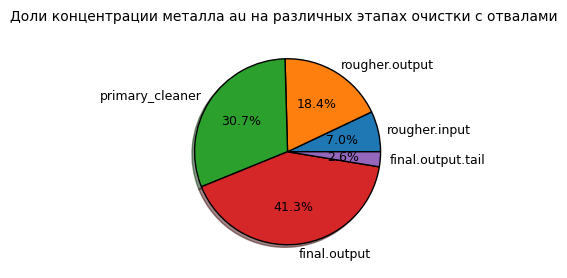

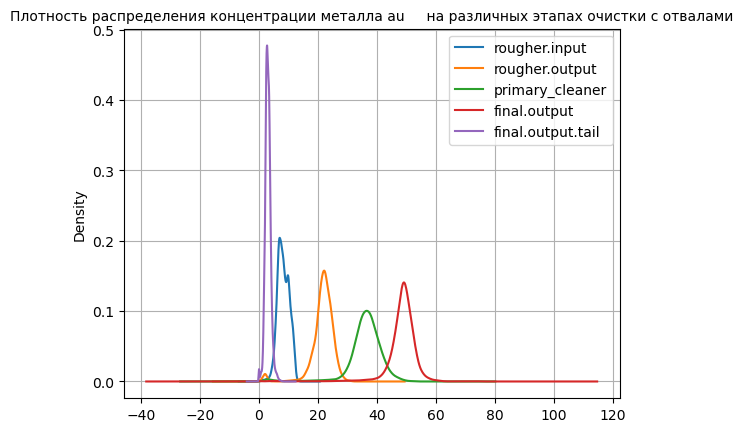

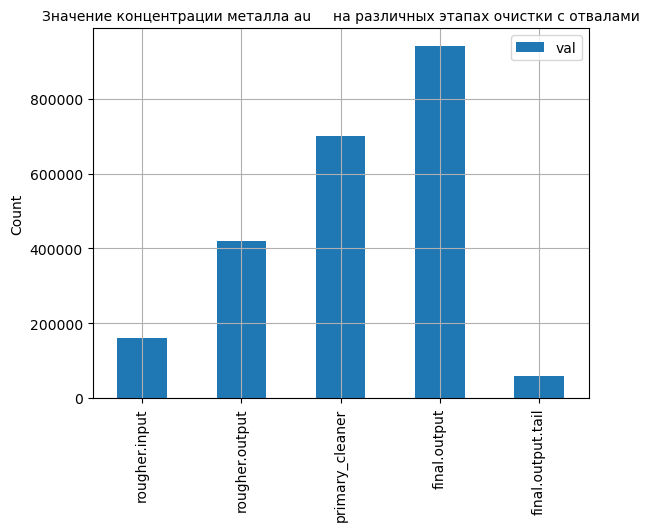

,val
rougher.input,160684.665932
rougher.output,419656.740560


,val
final.output,941161.297532
final.output.tail,59142.515527


,val
rougher.input,160684.665932
rougher.output,419656.740560
primary_cleaner,700456.747306
final.output,941161.297532
final.output.tail,59142.515527


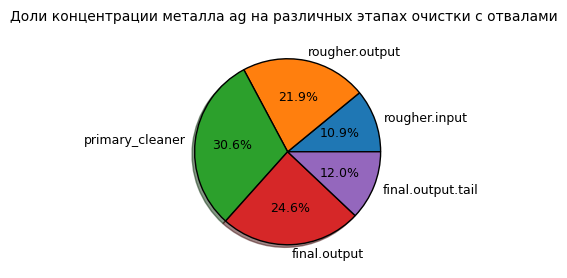

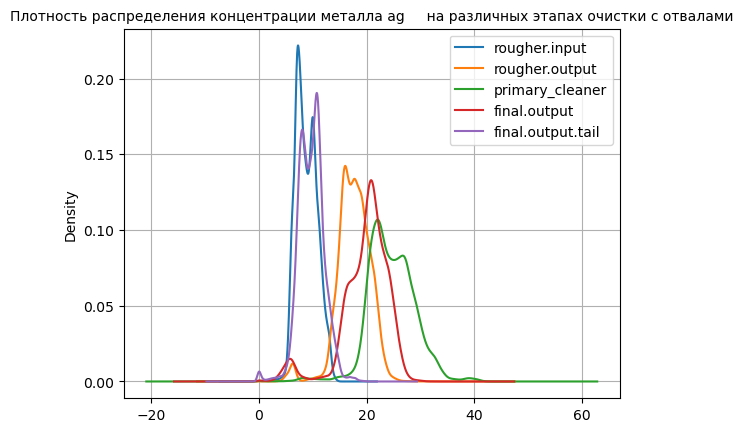

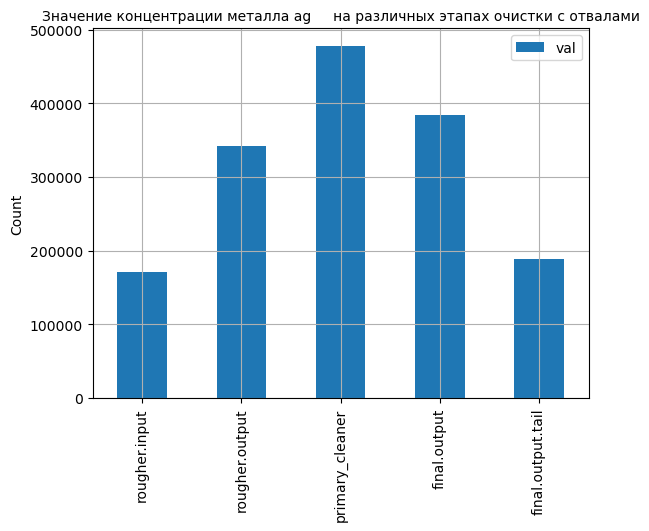

,val
rougher.input,170964.594230
rougher.output,341811.935464


,val
final.output,384019.522162
final.output.tail,188334.503497


,val
rougher.input,170964.594230
rougher.output,341811.935464
primary_cleaner,477971.881342
final.output,384019.522162
final.output.tail,188334.503497


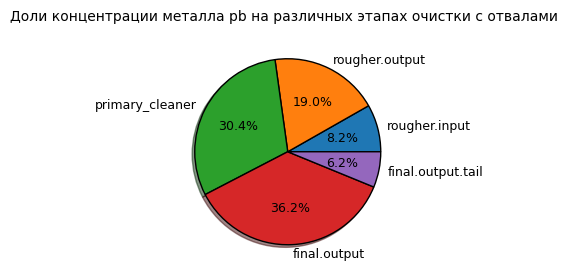

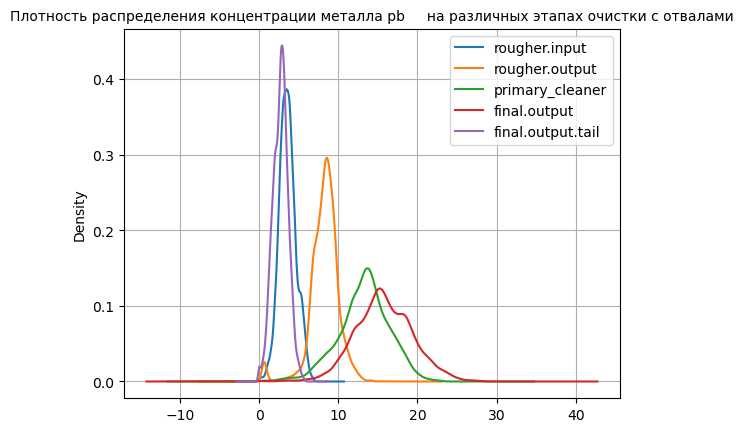

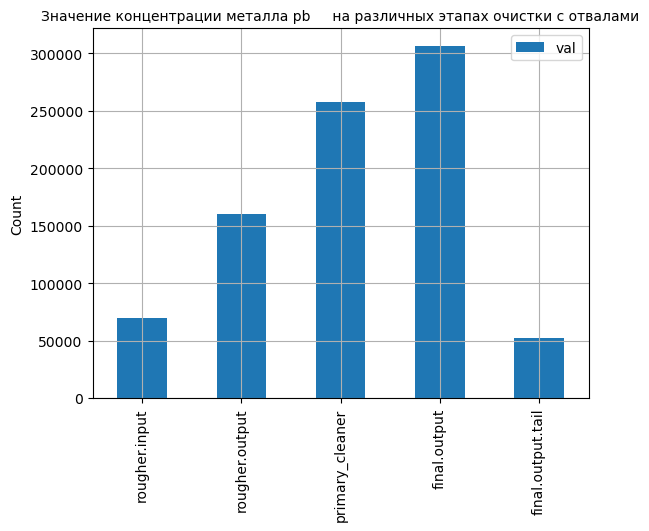

,val
rougher.input,69690.675538
rougher.output,160411.690784


,val
final.output,306266.286286
final.output.tail,52386.096386


,val
rougher.input,69690.675538
rougher.output,160411.690784
primary_cleaner,257447.684475
final.output,306266.286286
final.output.tail,52386.096386


[None, None, None]

In [ ]:
# Выведем графики концентрации металлов на различных этапах с хвостами
[concetrate_stages(dct['full'], metalls[x], [], True) for x in range(len(metalls)-1)]

#### Концентрация металлов (Au, Ag, Pb) без отвальных хвостов  до удаления выбросов

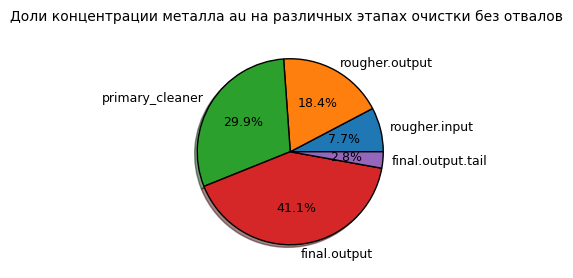

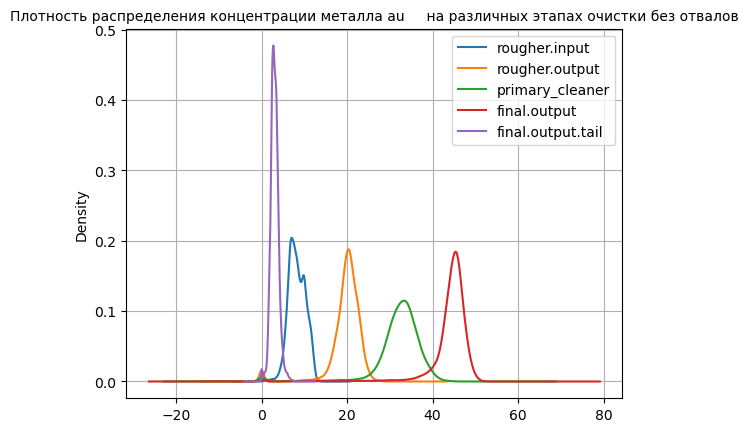

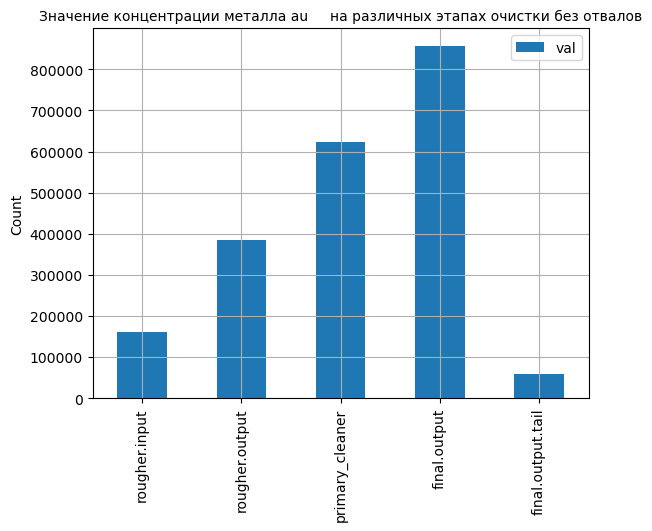

,val
rougher.input,160684.665932
rougher.output,384347.910711


,val
final.output,856803.335079
final.output.tail,59142.515527


,val
rougher.input,160684.665932
rougher.output,384347.910711
primary_cleaner,624369.024529
final.output,856803.335079
final.output.tail,59142.515527


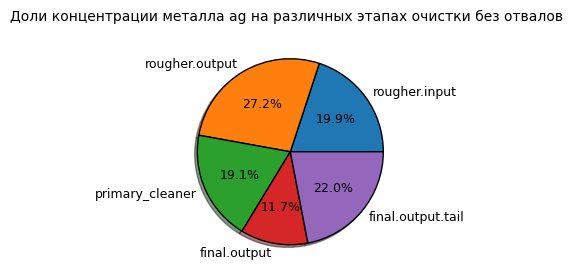

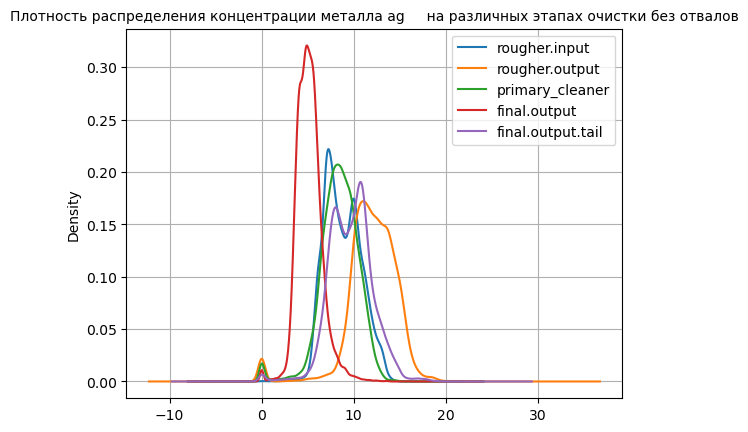

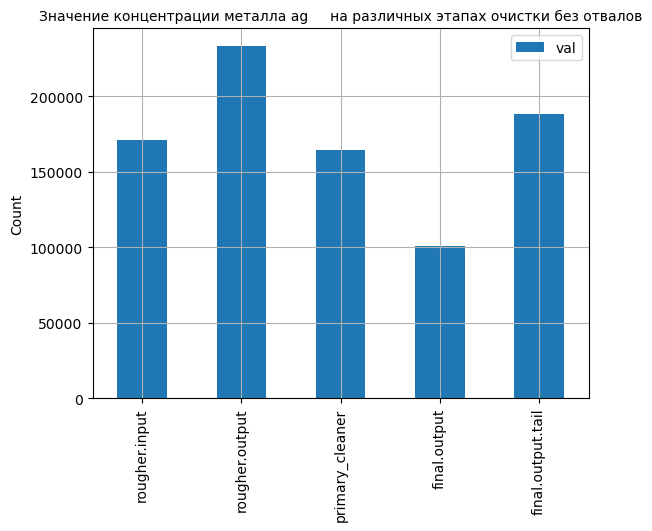

,val
rougher.input,170964.594230
rougher.output,233166.127197


,val
final.output,100468.274261
final.output.tail,188334.503497


,val
rougher.input,170964.594230
rougher.output,233166.127197
primary_cleaner,164111.970623
final.output,100468.274261
final.output.tail,188334.503497


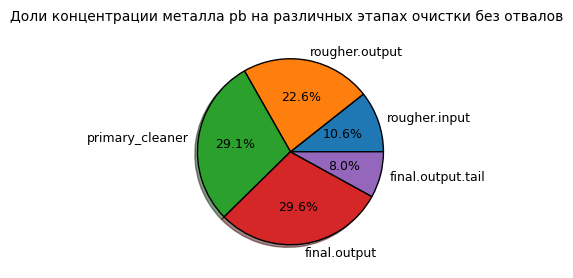

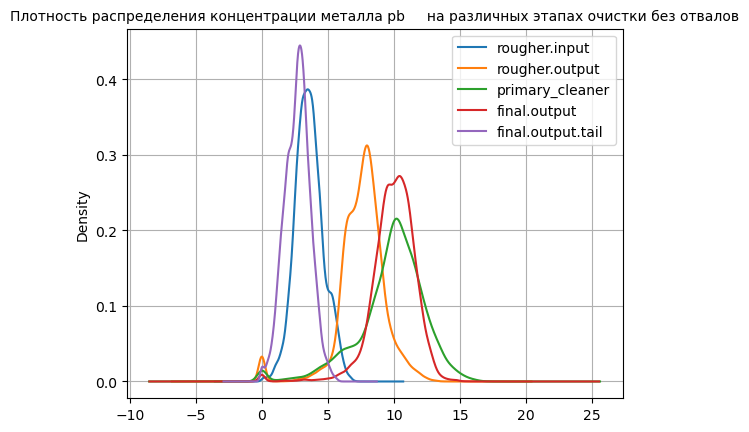

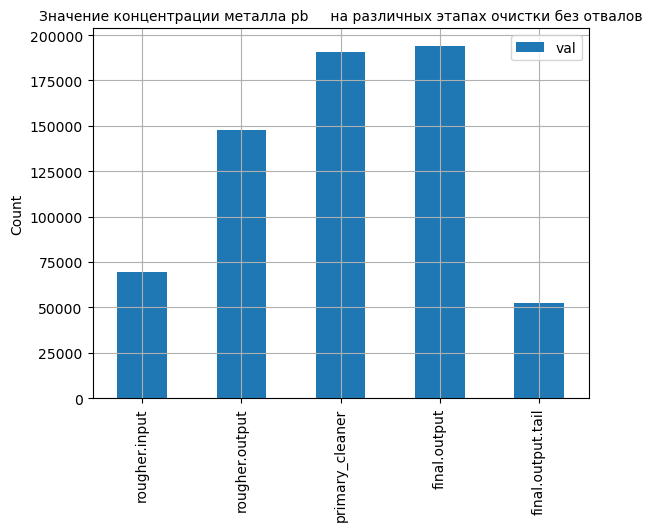

,val
rougher.input,69690.675538
rougher.output,147858.327496


,val
final.output,193978.308887
final.output.tail,52386.096386


,val
rougher.input,69690.675538
rougher.output,147858.327496
primary_cleaner,190702.743208
final.output,193978.308887
final.output.tail,52386.096386


[None, None, None]

In [ ]:
# Выведем графики концентрации металлов на различных этапах без хвостов
[concetrate_stages(dct['full'], metalls[x], [], False) for x in range(len(metalls)-1)]

### Концентрация металлов (Au, Ag, Pb) с отвальными хвостами после удаления выбросов

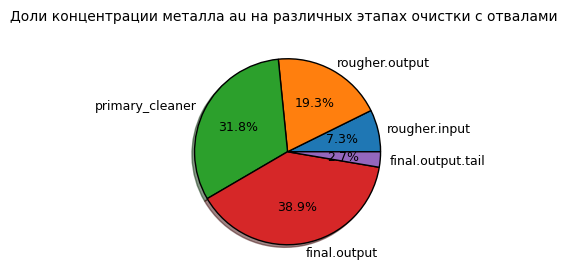

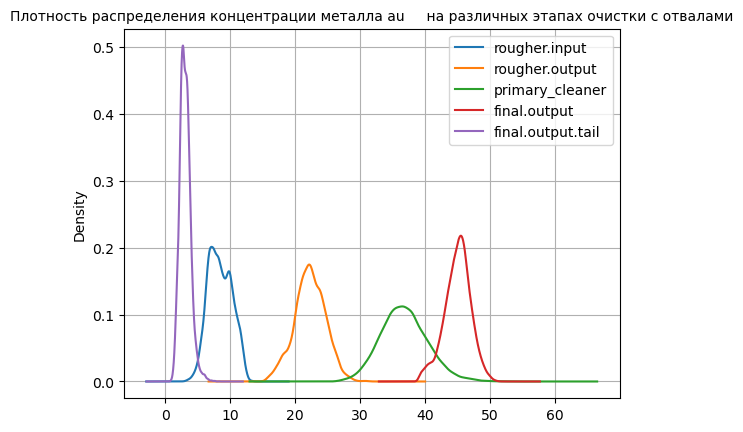

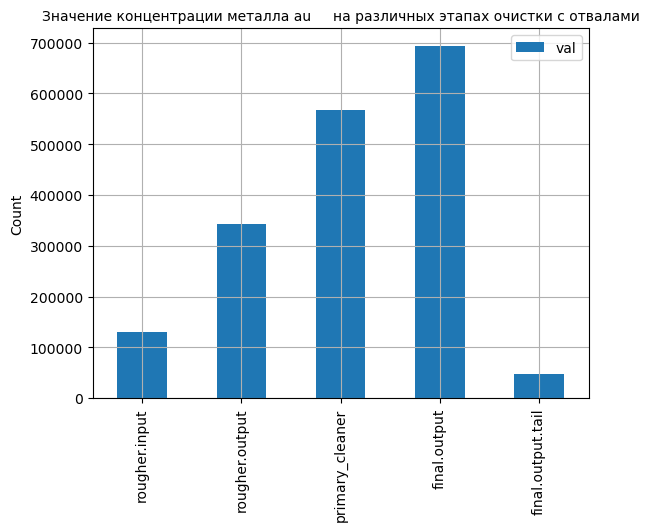

,val
rougher.input,130239.198542
rougher.output,343523.414707


,val
final.output,693476.216236
final.output.tail,47610.110514


,val
rougher.input,130239.198542
rougher.output,343523.414707
primary_cleaner,566989.457301
final.output,693476.216236
final.output.tail,47610.110514


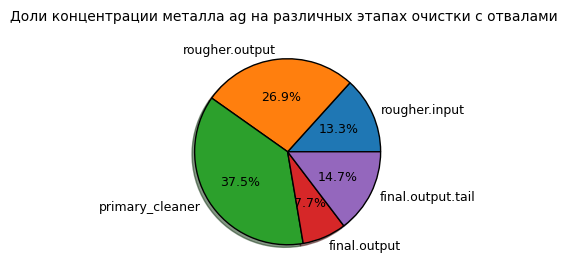

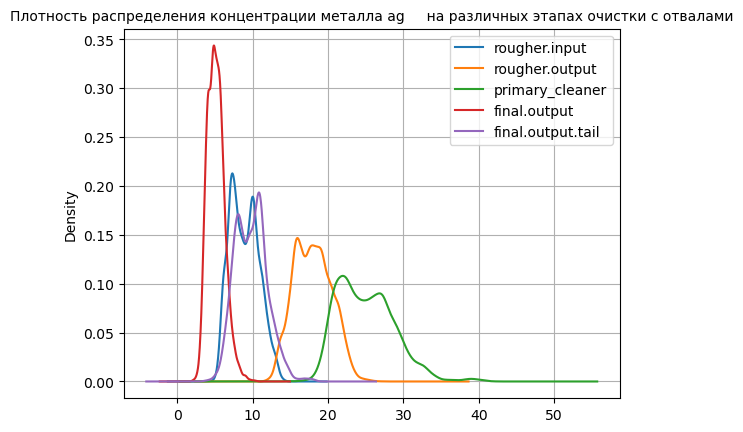

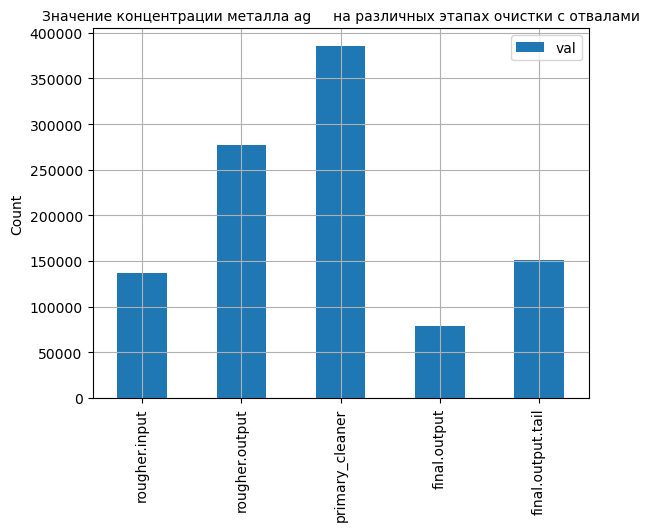

,val
rougher.input,136863.822696
rougher.output,276782.696176


,val
final.output,78726.472281
final.output.tail,150884.030007


,val
rougher.input,136863.822696
rougher.output,276782.696176
primary_cleaner,385530.558520
final.output,78726.472281
final.output.tail,150884.030007


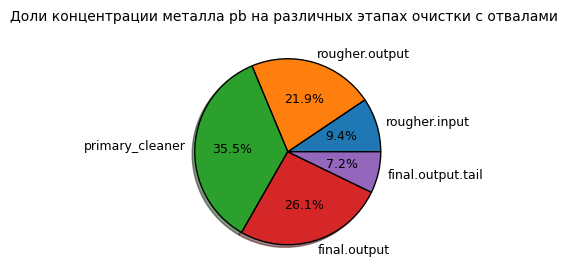

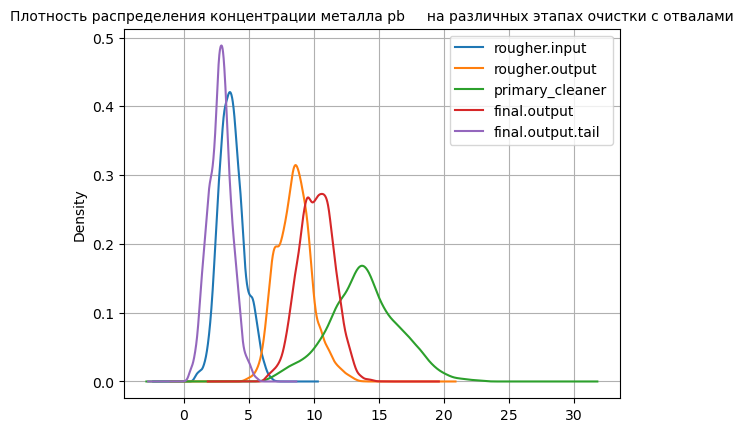

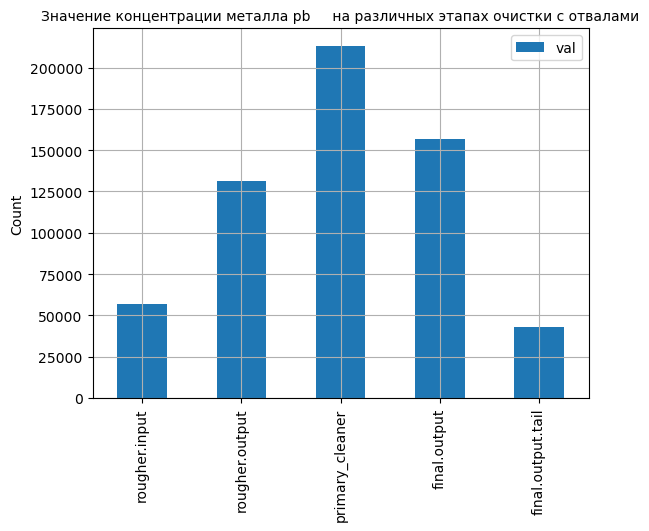

,val
rougher.input,56691.077885
rougher.output,131302.590573


,val
final.output,156706.246200
final.output.tail,43154.192709


,val
rougher.input,56691.077885
rougher.output,131302.590573
primary_cleaner,213028.944671
final.output,156706.246200
final.output.tail,43154.192709


[None, None, None]

In [ ]:
# Выведем графики концентрации металлов на различных этапах с хвостами после удаления выбросов
[concetrate_stages(full_clean, metalls[x], [], True) for x in range(len(metalls)-1)]

### Концентрация металлов (Au, Ag, Pb) без отвальных хвостов после удаления выбросов

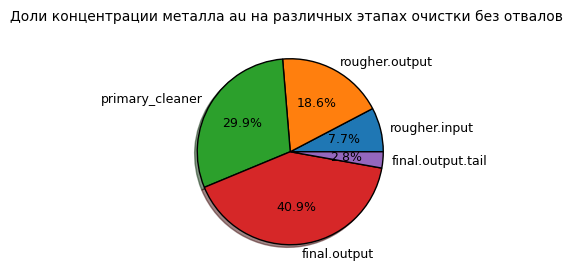

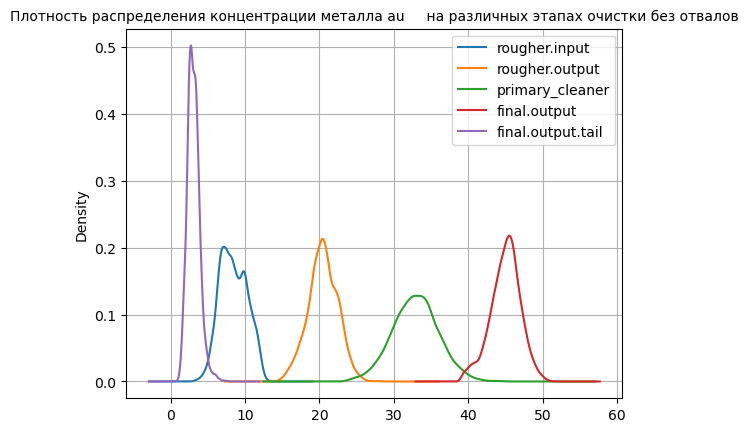

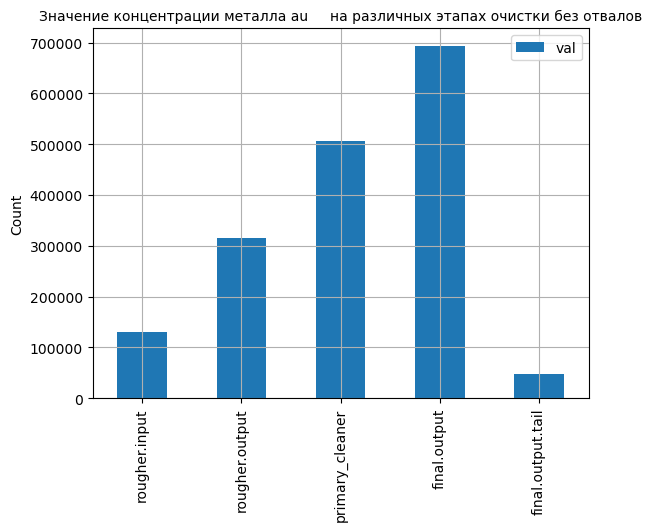

,val
rougher.input,130239.198542
rougher.output,315533.674261


,val
final.output,693476.216236
final.output.tail,47610.110514


,val
rougher.input,130239.198542
rougher.output,315533.674261
primary_cleaner,507252.326546
final.output,693476.216236
final.output.tail,47610.110514


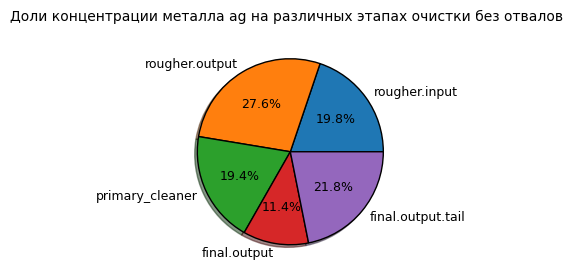

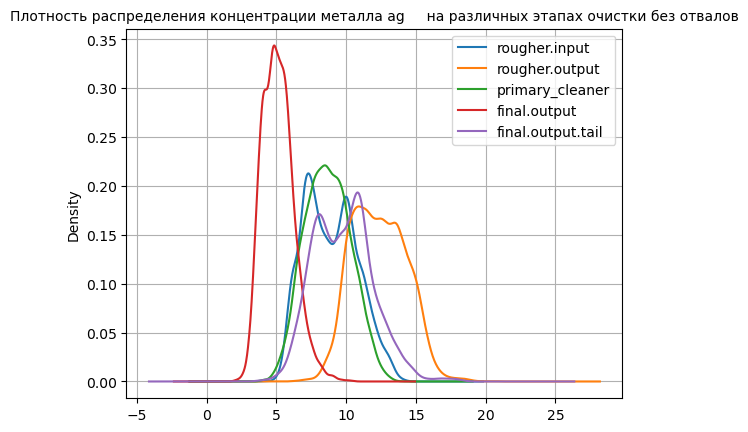

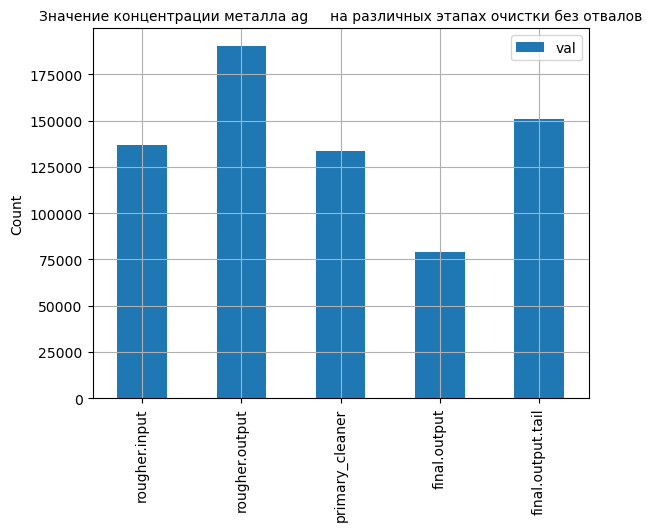

,val
rougher.input,136863.822696
rougher.output,190380.174203


,val
final.output,78726.472281
final.output.tail,150884.030007


,val
rougher.input,136863.822696
rougher.output,190380.174203
primary_cleaner,133698.699304
final.output,78726.472281
final.output.tail,150884.030007


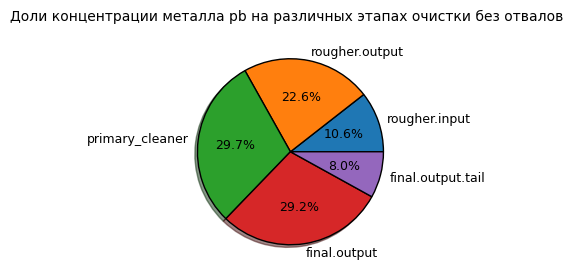

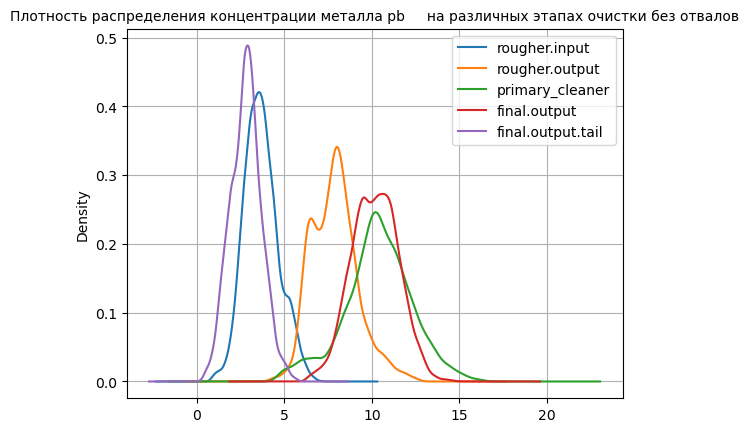

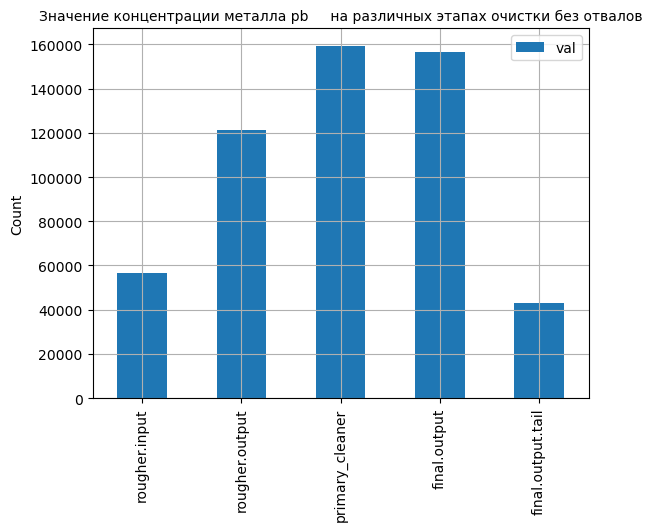

,val
rougher.input,56691.077885
rougher.output,121264.472590


,val
final.output,156706.246200
final.output.tail,43154.192709


,val
rougher.input,56691.077885
rougher.output,121264.472590
primary_cleaner,159274.170941
final.output,156706.246200
final.output.tail,43154.192709


[None, None, None]

In [ ]:
# Выведем графики концентрации металлов на различных этапах без хвостов после удаления выбросов
[concetrate_stages(full_clean, metalls[x], [], False) for x in range(len(metalls)-1)]

### Вывод 2.1
Посмотрели, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки с отвалами и без них, с удалением и без удаления выбросов.  
До удаления выбросов концентрация злота увеличивается до 41.3%, оставляя в финальном отвале 2,6%, на каждом этапе концентрация повышается приблизительно равными темпами, без отвальных хвостов в финальной стадии очистки концентрация снижается до 41,1%. На финальном этапе золото имеет наибольшую концентрацию и с отвалами составляет 41,3 % до удаления выбросов.Выбросы около нулевого значения могут быть связаны с ошибками получения данных от приборов.  
У серебра распределение концентрации по этапам другое, возможно, это связано с особенностями технологии очистки. К
финальному этапу она уменьшается в продукте, а в отвале имеет большую концентрацию.  
Распределение концентрации свинца схоже с распределением золота: к финальному этапу концентрация увеличивается до 29%,
оставляя около 8 % в отвале.  
Удаление выбросов незначительно сказывается на изменение концентраций.

## 2.2.  Сравните распределения размеров гранул сырья на обучающей и тестовой выборках.

In [ ]:
# Найдем нужный признак
feed_size = d.colsFilter(['rougher'], [], ['size'])
feed_size = feed_size[0]
feed_size

'rougher.input.feed_size'

In [ ]:
# Функция вывода графиков распределения размеров гранул сырья в обучающей и тестовой выборках
def kde(df_name, feed_size):
    fig, ax = plt.subplots()
    [
       [    dct[x][feed_size].plot(kind='kde', grid=True), \
            ax.axvline(x = dct[x][feed_size].mean(), \
                       color = 'r', linestyle = 'dashed', label = f'mean {x}'), \
            ax.axvline(x = dct[x][feed_size].median(), \
                       color = 'y', linestyle = 'dashed', label = f'median {x}'), \
            plt.legend(fontsize=8), \
            plt.title(f'Распределение размеров гранул сырья с медианой и средним train {x}', \
                      fontsize=10), \
            plt.xlim(-10, 150)
       ] for x in df_name
    ]

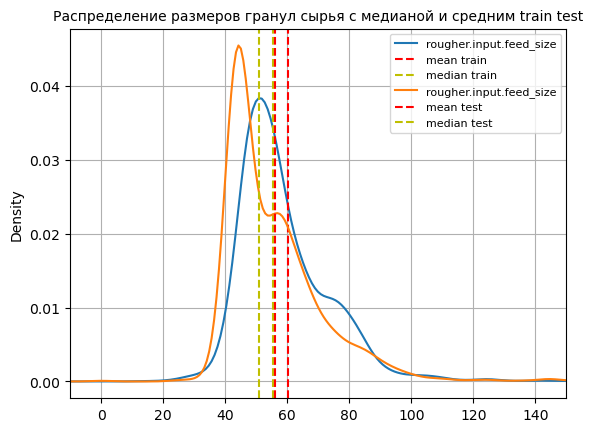

In [ ]:
# Вывод графика
kde(['train', 'test'], feed_size)

In [ ]:
# Статистики распределения размеров гранул сырья на обучающей выборке
display(pd.DataFrame(dct['train'][feed_size].describe()))

,rougher.input.feed_size
count,14149.000000
mean,60.239856
std,23.005310
min,9.659576
25%,48.966751
50%,55.269784
75%,66.007526
max,484.967466


In [ ]:
# Статистики распределения размеров гранул сырья на тестовой выборке
display(pd.DataFrame(dct['test'][feed_size].describe()))

,rougher.input.feed_size
count,5290.000000
mean,55.952754
std,19.080334
min,0.046369
25%,43.906504
50%,50.846843
75%,62.451165
max,392.494040


## Вывод 2.2
Сравнили распределения размеров гранул сырья на обучающей и тестовой выборках
Распределения размеров гранул сырья в выборках схожи.  
Средние близки.

## 2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [ ]:
# Потенциально необхоимые признаки
d.colsFilter(['feed', 'rougher', 'final'], metalls, [])

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au']

#### Концентрации всех металлов на различных этапах с отвалами без выбросов

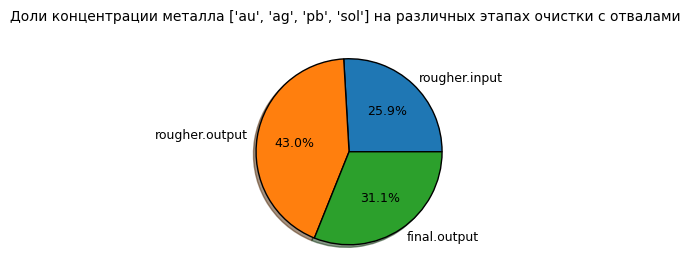

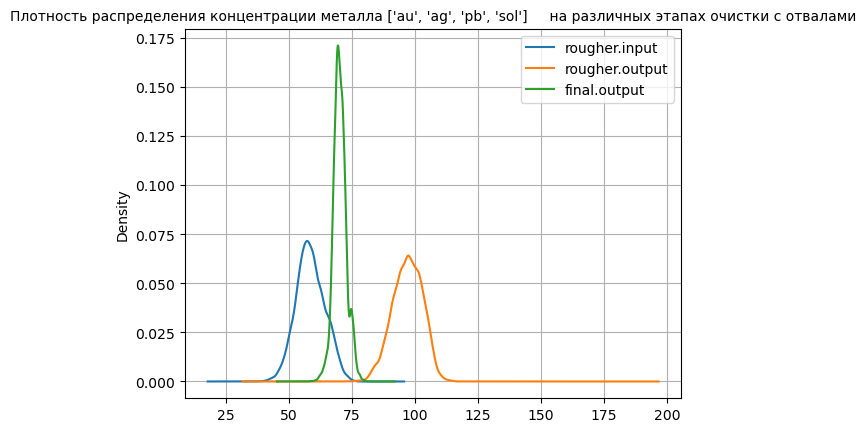

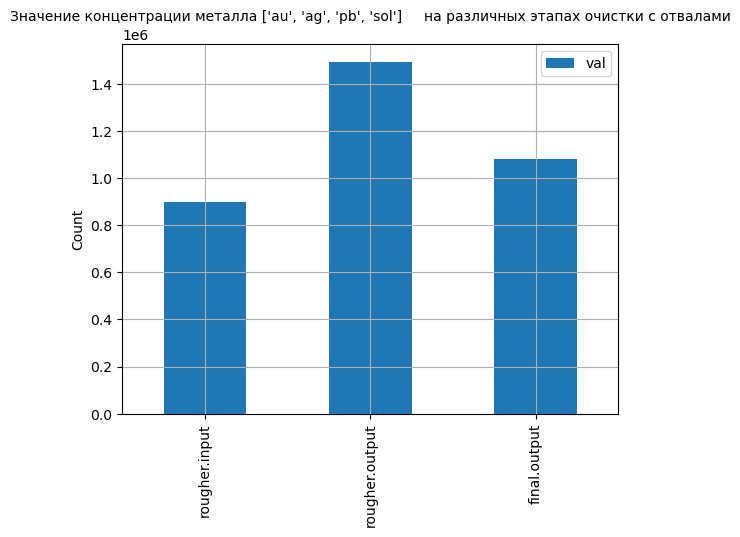

,val
rougher.input,9.004497e+05
rougher.output,1.494063e+06


,val
rougher.output,1.494063e+06
final.output,1.079969e+06


,val
rougher.input,9.004497e+05
rougher.output,1.494063e+06
final.output,1.079969e+06


In [ ]:
# Выведем графики концентрации всех металлов на различных этапах с отвалами без выбросов
concetrate_stages(full_clean, metalls, ['rougher.input', 'rougher.output', 'final.output'], True)

#### Концентрации всех металлов на различных этапах без отвалов без выбросов

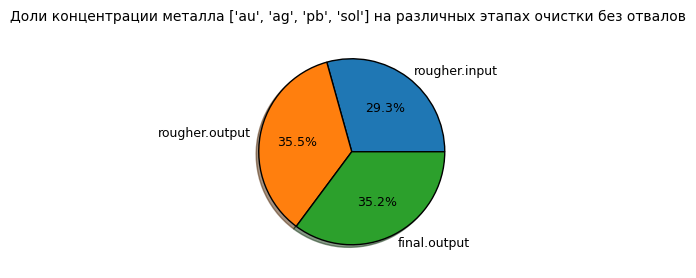

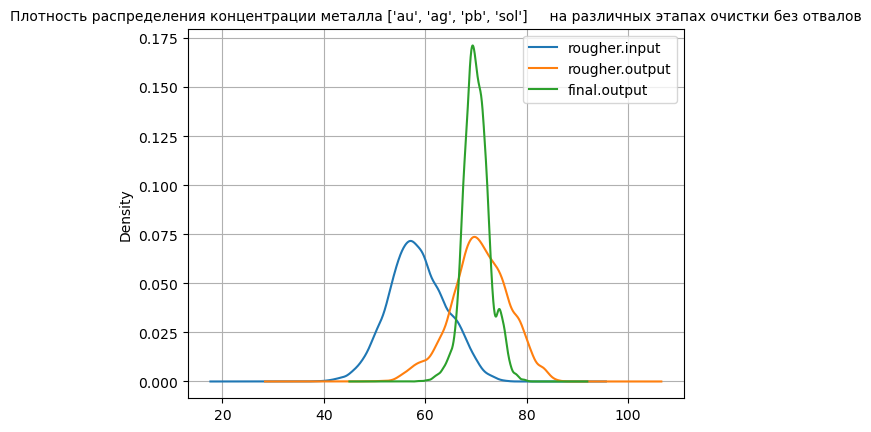

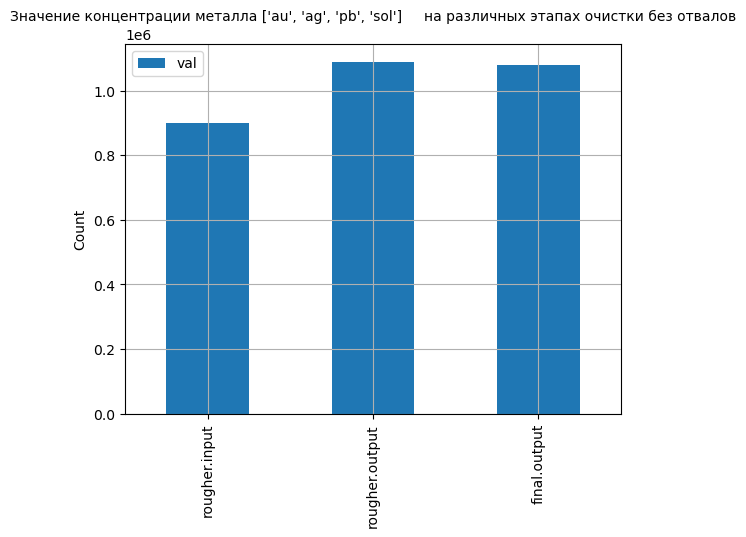

,val
rougher.input,9.004497e+05
rougher.output,1.089987e+06


,val
rougher.output,1.089987e+06
final.output,1.079969e+06


,val
rougher.input,9.004497e+05
rougher.output,1.089987e+06
final.output,1.079969e+06


In [ ]:
# Выведем графики концентрации всех металлов на различных этапах без отвалов без выбросов
concetrate_stages(full_clean, metalls, ['rougher.input', 'rougher.output', 'final.output'], False)

## Вывод 2.3  
Исследовали суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Наибольшая концентрация веществ в черновом концентрате. К финальному этапу распределение приближается к нормальному.

## 3.1 Функция для вычисления итоговой sMAPE.

In [ ]:
# функция для вычисления sMAPE
def smape_score (target, predict):
    smape_sc = 100*np.mean(abs(target - predict)/((abs(target)+abs(predict))/2))
    return smape_sc

In [ ]:
# функция для вычисления итоговой sMAPE
def smape_common (rougher, final):
    smape_scm = 0.25*rougher + 0.75*final
    return smape_scm

## 3.2 Обучим разные модели и оценим их качество кросс-валидацией.

In [ ]:
# Выведем размеры выборок для проверки
print(x_train_drop_scaler.shape,
y_train_rougher.shape,
y_train_final.shape)

(9573, 48) (9573,) (9573,)


### Создаем функцию метрики sMAPE

In [ ]:
def smape_score (target, predict):
    smape_sc = 100 / len(target) * np.sum(2*np.abs(target - predict) / ((np.abs(target) + np.abs(predict))))
    #smape_sc = cross_val_score(model, target, predict, scoring = smape)
    #smape_sc = smape_sc.mean
    return smape_sc

In [ ]:
def smape_common(rouger, final):
    smape_common =  0.25*rouger + 0.75*final
    return smape_common

In [ ]:
# Функция для получения лучших параметров (из заданных для них диапазонов) указанной модели
# На вход подется модель машинного обучения и словарь параметров с заданным диапазоном
# На выходе получаем модель с лучшими параметрами, обученную на выборке train,
# и метрику f1
#smape_scoring = 100 * (target - predict).abs().sum() / (len(target) * ((target.abs() + predict.abs()) / 2))
 # функция для вычисления sMAPE

smape_sc = make_scorer(smape_score, greater_is_better=False)
n_iter_search = 15

def best_model (model, param_dict, features, targets):

    model_rs = RandomizedSearchCV(estimator=model, \
                                  param_distributions=param_dict, \
                                  n_iter=n_iter_search, cv=10, \
                                  n_jobs=20, verbose=1, \
                                  scoring=smape_sc)
    model_rs.fit(features, targets)
    best_model = model_rs.best_estimator_
    best_score = model_rs.best_score_

    return best_score, best_model

In [ ]:
# Словарь лучших моделей и их метрик smape
scores_models= {}

### Выбор модели

In [ ]:
# Задаем модель Случайный лес и ее параметры
model_rfc = RandomForestRegressor(random_state=RS) # Создаем объект модели
# Задаем диапазон остальным параметрам модели для обучения
param_rfc = {'n_estimators': range(20, 50, 5), 'max_depth': range(1, 8, 1)}

In [ ]:
# Задаем модель Дерево решений и ее параметры
model_dtc = DecisionTreeRegressor(random_state=RS) # Создаем объект модели
# Задаем диапазон остальным параметрам модели для обучения
param_dtc = {'max_depth': range(1, 25, 1)}

In [ ]:
# Задаем модель Линейная регрессия
model_lr = LinearRegression()
param_lr = {}

In [ ]:
def best_smape (model, parameters):

    rouger_smape, rouger_model = best_model(model, parameters, x_train_drop_scaler, y_train_rougher)
    final_smape, final_model = best_model(model, parameters, x_train_drop_scaler, y_train_final)
    smape_com = smape_common(rouger_smape, final_smape)

    return rouger_model, final_model, smape_com

In [ ]:
%%time
scores_models['model_rfc'] = best_smape(model_rfc, param_rfc)
scores_models['model_dtc'] = best_smape(model_dtc, param_dtc)
scores_models['model_lr'] = best_smape(model_lr, param_lr)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Fitting 10 folds for each of 15 candidates, totalling 150 fits
Fitting 10 folds for each of 15 candidates, totalling 150 fits
Fitting 10 folds for each of 15 candidates, totalling 150 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Wall time: 2min 53s


In [ ]:
scores_models

{'model_rfc': (RandomForestRegressor(max_depth=5, n_estimators=35, random_state=1234),
  RandomForestRegressor(max_depth=3, n_estimators=25, random_state=1234),
  -9.695702604792384),
 'model_dtc': (DecisionTreeRegressor(max_depth=1, random_state=1234),
  DecisionTreeRegressor(max_depth=3, random_state=1234),
  -10.114269157340354),
 'model_lr': (LinearRegression(), LinearRegression(), -10.09984400151929)}

In [ ]:
list(map(lambda x: [print(f'{scores_models[x][2]} sMAPE наилучшей модели'), \
                   display(scores_models[x][1])], scores_models))

-9.695702604792384 sMAPE наилучшей модели


RandomForestRegressor(max_depth=3, n_estimators=25, random_state=1234)

-10.114269157340354 sMAPE наилучшей модели


DecisionTreeRegressor(max_depth=3, random_state=1234)

-10.09984400151929 sMAPE наилучшей модели


LinearRegression()

[[None, None], [None, None], [None, None]]

In [ ]:
# Функция для вывода гистограммы f1-метрики лучших моделей
# На входе - словарь лучших моделей и их метрик f1, обученных при разных условиях
def hist_best_models (scores_mod):
    df_scores_best = pd.DataFrame.from_dict(scores_mod, orient='index', columns=['','model', 'smape'])# 'f1_test'])
    plt.figure(figsize=(12,6))
    plt.title('Гистограмма метрики smape лучших моделей на обучающей выборке', fontsize=15)
    sns.barplot(data=df_scores_best, x=df_scores_best.index, y='smape', palette='hls', alpha=0.8)
    sns.set_style('darkgrid')
    plt.xlabel('Модели',fontsize=13)
    plt.ylabel(' sMAPE',fontsize=13)
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.show()

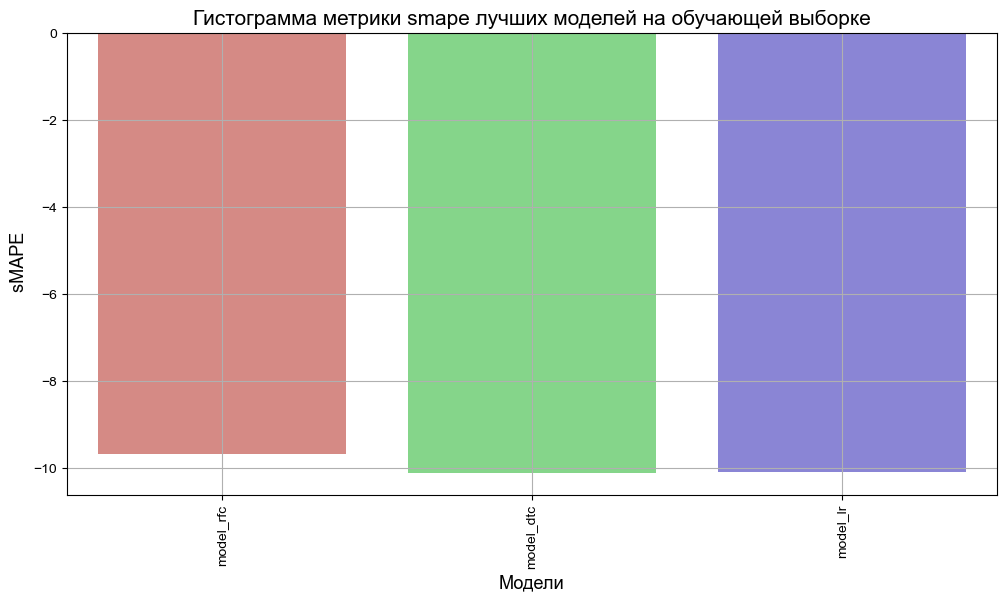

In [ ]:
# Гистограмма sMAPE-метрики лучших моделей на данном этапе
hist_best_models (scores_models)

In [ ]:
display(pd.DataFrame(scores_models, index=['best_models_rouger', 'best_models_final', 'sMAPE']))

,model_rfc,model_dtc,model_lr
best_models_rouger,"(DecisionTreeRegressor(max_depth=5, max_featur...","DecisionTreeRegressor(max_depth=1, random_stat...",LinearRegression()
best_models_final,"(DecisionTreeRegressor(max_depth=3, max_featur...","DecisionTreeRegressor(max_depth=3, random_stat...",LinearRegression()
sMAPE,-9.695703,-10.114269,-10.099844


Были рассмотрены 3 модели с разными гиперпараметрами, подбираемые и оцениваемые с помощью RandomizedSearchCV кросс-валидацией.  
Выбор модели осуществлялся по написанной нами метрике  - итоговой sMAPE  - согласно условию задачи.  
С небольшой разницей лучший результат показала модель  
RandomForestRegressor(max_depth=4, n_estimators=35, random_state=1234)  
ее sMAPE составила -10.3    

### Тестирование выбранной модели

In [ ]:
#scores_models['model_rfc'][0] # модель для целевого признака rouger
#scores_models['model_rfc'][1] # модель для целевого признака final

In [ ]:
# Предсказания модели на тестовой выборке для 2х целевых признаков
predict_rouger = scores_models['model_rfc'][0].predict(x_test_drop_scaler)
predict_final  = scores_models['model_rfc'][1].predict(x_test_drop_scaler)

smape_rouger = smape_score(y_test_rougher, predict_rouger)
smape_final = smape_score(y_test_final, predict_final)

smape_best = smape_common(smape_rouger, smape_final)
print(f'sMAPE на выбранной модели на тестовой выборке покоазало результат {round(smape_best,2)}%')

sMAPE на выбранной модели на тестовой выборке покоазало результат 9.89%


In [ ]:
### Проверка выбранной модели на адекватность

In [ ]:
# Предсказания базовой модели на тестовой выборке для 2х целевых признаков
dummy_rougher = DummyRegressor(strategy="mean")
dummy_final = DummyRegressor(strategy="mean")

dummy_rougher.fit(x_train_drop_scaler, y_train_rougher)
dummy_final.fit(x_train_drop_scaler, y_train_final)

predict_dummy_rouger = dummy_rougher.predict(x_test_drop_scaler)
predict_dummy_final  = dummy_final.predict(x_test_drop_scaler)

smape_dummy_rouger = smape_score(y_test_rougher, predict_dummy_rouger)
smape_dummy_final = smape_score(y_test_final, predict_dummy_final)

smape_dummy_best = smape_common(smape_dummy_rouger, smape_dummy_final)
smape_dummy_best

9.955810196136078

## **Общий вывод**  

При изучении данных было выявлено следущее.
Обучающая выборка содержит 14149 строк и 87 признаков.
- Явных дубликатов нет.  
- Содержит пропуски более 9% в столце secondary_cleaner.output.tail_sol  

Тестовая  выборка содержит  5290 строк и 53 признака.  
- Явных дубликатов нет.  
- Содержит незначительное количество пропусков.  

Полная  выборка содержит  19439 строк и 87 признаков.  
- Явных дубликатов нет.  
- Содержит пропуски более 8% в столце secondary_cleaner.output.tail_sol

Признаки в данных количественные, кроме `date`.
Большинство признаков имеют выбросы и распределены ненормально.

Проверили, что эффективность обогащения (recovery) рассчитана правильно.
Рассчитанное MAE между расчетным и значением признака в обучающей выборке составило 1.1**-14, что говорит о верном расчете эффективности обогащения (recovery).

Проанализировали признаки, недоступные в тестовой выборке.
В тестовой выборке отсуствует 34 признака: параметры выхода продукта (output) - концентраций металлов au, agб, pb и вещества sol в отвалах и концентрате для каждого из этапов процесса очистки   
отсутствуют и расчётные характеристики во флотационной установке (calculation) для исходного сырья -, а также целевые признаки  
`rougher.output.recovery`  
`final.output.recovery`  

Можно предположить, что отсуствие признаков связано с выстроенным поэтапным процессом очистки и для расчета характеристик каждого нужно время.
Данные характеристики не будут участвовать при обучении модели, в том числе и потому, что регулировать мы можем только  состояние флотационных реагентов (эти данные и включены в тестовые признаки), чтобы подобрать более оптимальный процесс очистки, повышающий эффективность обогощения руды, что поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Выборки были подготовлены для обучения моделей
Для обучающей выборки
- выделили целевые признаки из нее
- удалили признак с датой и временем `date`
- удалили мультиколлинеарные признаки с порогом корреляции в 0.98, пересекающиеся с тестовой выборкой(тк влияет на переобучение модели)
- удалили признаки, которых нет в тестовой выборке (з4 признака)
- удалили выбросы в оставшихся признаках
- отмасштабировали признаки с помощью MinMaxScaler (тк рапределения признаков ненормальные)

Для тестовой выборки  
- выделили целевые признаки из полного датасета по совпадающим индексам `date`
- удалили признак с датой и временем `date`
- отмасштабировали признаки с помощью MinMaxScaler (тк рапределения признаков ненормальные)
После обработки данных осталось 48 признаков для обучения моделей.

Посмотрели, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки с отвалами и без них, с удалением и без удаления выбросов.  
До удаления выбросов концентрация злота увеличивается до 41.3%, оставляя в финальном отвале 2,6%, на каждом этапе концентрация повышается приблизительно равными темпами, без отвальных хвостов в финальной стадии очистки концентрация снижается до 41,1%. На финальном этапе золото имеет наибольшую концентрацию и с отвалами составляет 41,3 % до удаления выбросов.Выбросы около нулевого значения могут быть связаны с ошибками получения данных от приборов.  
У серебра распределение концентрации по этапам другое, возможно, это связано с особенностями технологии очистки. К
финальному этапу она уменьшается в продукте, а в отвале имеет большую концентрацию.  
Распределение концентрации свинца схоже с распределением золота: к финальному этапу концентрация увеличивается до 29%,
оставляя около 8 % в отвале.  
Удаление выбросов незначительно сказывается на изменение концентраций.  

Сравнили распределения размеров гранул сырья на обучающей и тестовой выборках.  
Распределения размеров гранул сырья в выборках схожи.  
Средние близки.  
Исследовали суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Наибольшая концентрация веществ в черновом концентрате. К финальному этапу распределение приближается к нормальному.  


Были рассмотрены 3 модели Случайный лет, Дерево решений и Линейная модель с разными гиперпараметрами, подбираемые и оцениваемые с помощью RandomizedSearchCV кросс-валидацией.  
Выбор модели осуществлялся по написанной нами функции для вычисления итоговой метрики  - итоговой sMAPE  - согласно условию задачи.  
С небольшой разницей на обучающих данных лучший результат по нашей мерике показала модель
RandomForestRegressor(max_depth=5, n_estimators=35, random_state=1234) - для прогноза признака эффективность обогащения чернового концентрата **rougher.output.recovery** и  
RandomForestRegressor(max_depth=3, n_estimators=25, random_state=1234) - для прогноза признака эффективность обогащения финального концентрата **final.output.recovery**.  
Итоговое sMAPE ее прогноза   
на обучающей выборке составила 9.7%  
на тестовой 9.89%  
Модель прошла оценку на адекватность: базовая модель показала результат в 9,96%.